# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: Povos e Comunidades Tradicionais

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- Caio Vinicius F. de Araujo
- Guilherme Mendes Pereira
- Julio Cesar Litwin Lima
- Lucas Gomes de Oliveira
- Lucas Gomes Silva
- Lucas Maciel Aguiar
- Miguel Henrique de O. Alves

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PCTs-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
99,duplicated_lines_density,0.0,True,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
100,functions,9,NaN,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
101,security_rating,1.0,True,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
102,files,20,NaN,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
103,complexity,18,NaN,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
104,ncloc,359,NaN,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
105,coverage,83.1,False,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
106,reliability_rating,1.0,True,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
107,comment_lines_density,16.1,False,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
90,duplicated_lines_density,0.0,True,fga-eps-mds_2021_1-PCTs-Documents-API-07-10-20...,Documents,API-07-10-2021-07-31


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df_ts = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')
        file_component_df_ts['filename'] = os.path.basename(i)

        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        file_component_df_js['filename'] = os.path.basename(i)

        file_component_df_py = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'py')
        file_component_df_py['filename'] = os.path.basename(i)

        file_component_df_yaml = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'yaml')
        file_component_df_yaml['filename'] = os.path.basename(i)

        df = df.append(file_component_df_ts, ignore_index=True)
        df = df.append(file_component_df_js, ignore_index=True)
        df = df.append(file_component_df_py, ignore_index=True)
        df = df.append(file_component_df_yaml, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PCTs-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [10]:
file_component_df = create_file_df(jsons)

In [11]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
167,documents/migrations/0001_initial.py,0,0,4.5,0.0,100.0,21,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
168,documents/migrations/0002_document_classificat...,0,0,7.7,0.0,100.0,12,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
169,documents/migrations/0003_auto_20211028_2212.py,0,0,3.0,0.0,100.0,32,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
170,pcts_documents/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
171,documents/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
172,documents/migrations/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
173,documents/tests/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
174,documents/admin.py,0,0,0.0,0.0,100.0,1,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
175,documents/apps.py,0,0,0.0,0.0,100.0,4,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35
176,pcts_documents/asgi.py,0,0,66.7,0.0,0.0,4,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021.1-PCTs-Documents-API-02-11-20...,Documents,API-02-11-2021-23-35


#### Create dataframe per repository

In [12]:
scraper_df = file_component_df[file_component_df['repository'] == 'Scraper']
documentsapi_df = file_component_df[file_component_df['repository'] == 'Documents-API']
mltraining_df = file_component_df[file_component_df['repository'] == 'ML-Training']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']

In [13]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0

        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0

        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [14]:
def m1(df):
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    return density_non_complex_files

##### COMMENTS

In [15]:
def m2(df):
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    return density_comment_files

##### DUPLICATIONS

In [16]:
def m3(df):
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [17]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [18]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds if not np.isnan(density_fast_test_builds) else 0

##### Test coverage

In [19]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [20]:
def create_metrics_df(df):

    version_vec = df['version'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list,
                               'version': version_list,
                               'ncloc': ncloc_list})

    return metrics_df

In [21]:
scraper_metrics = create_metrics_df(scraper_df)
documentsapi_metrics = create_metrics_df(documentsapi_df)
mltraining_metrics = create_metrics_df(mltraining_df)
frontend_metrics = create_metrics_df(frontend_df)

### Data visualization

- You must do this for each of your repositories

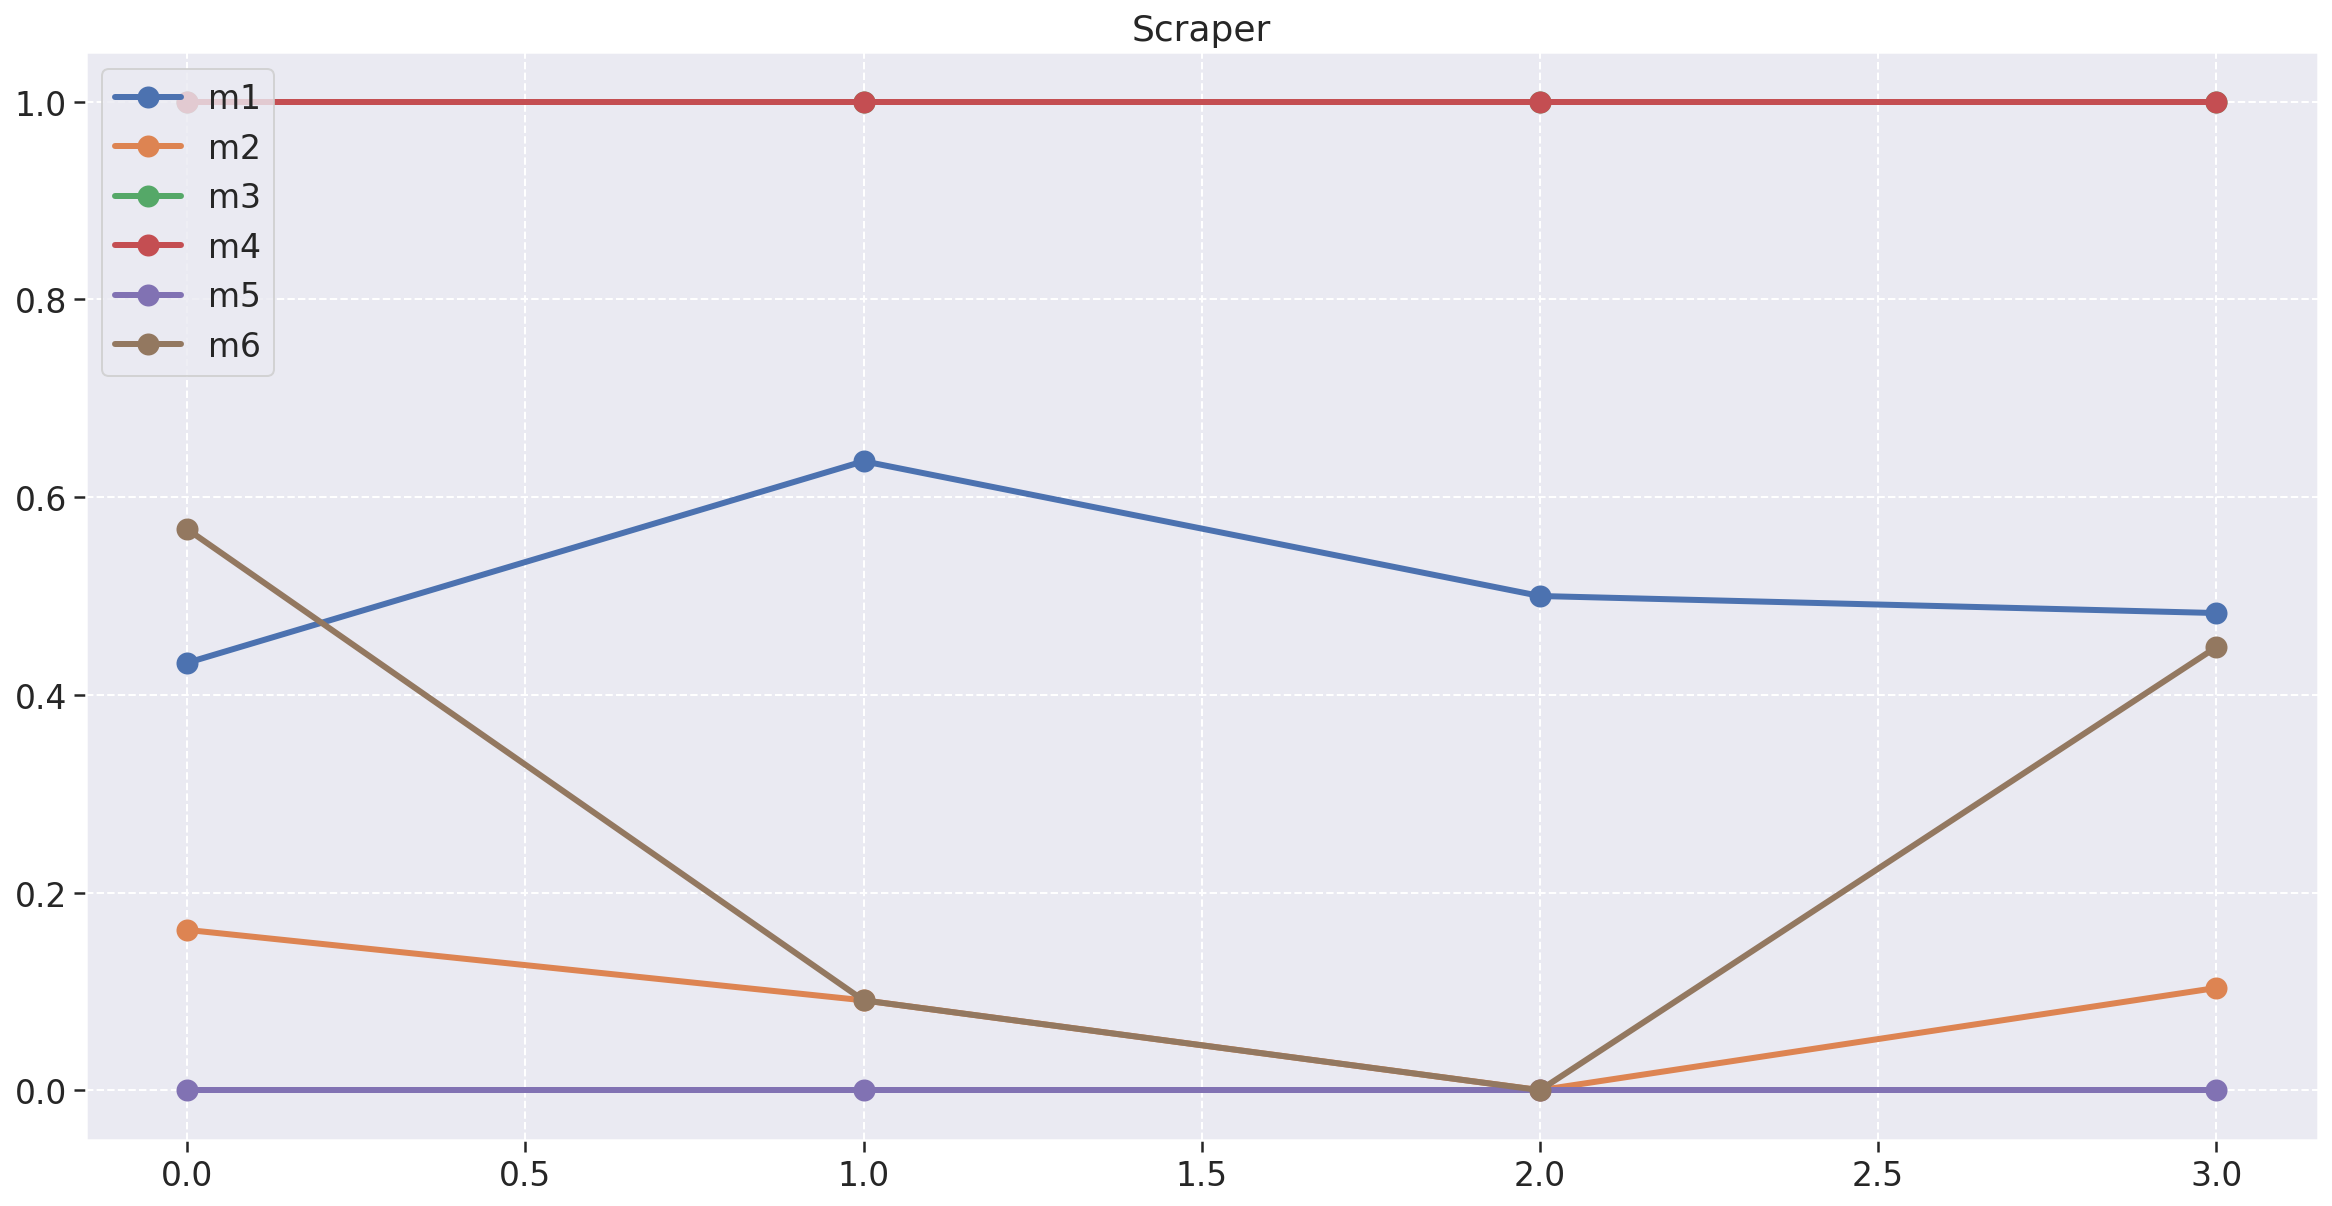

In [22]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper')
plt.plot(scraper_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(scraper_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(scraper_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(scraper_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(scraper_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(scraper_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

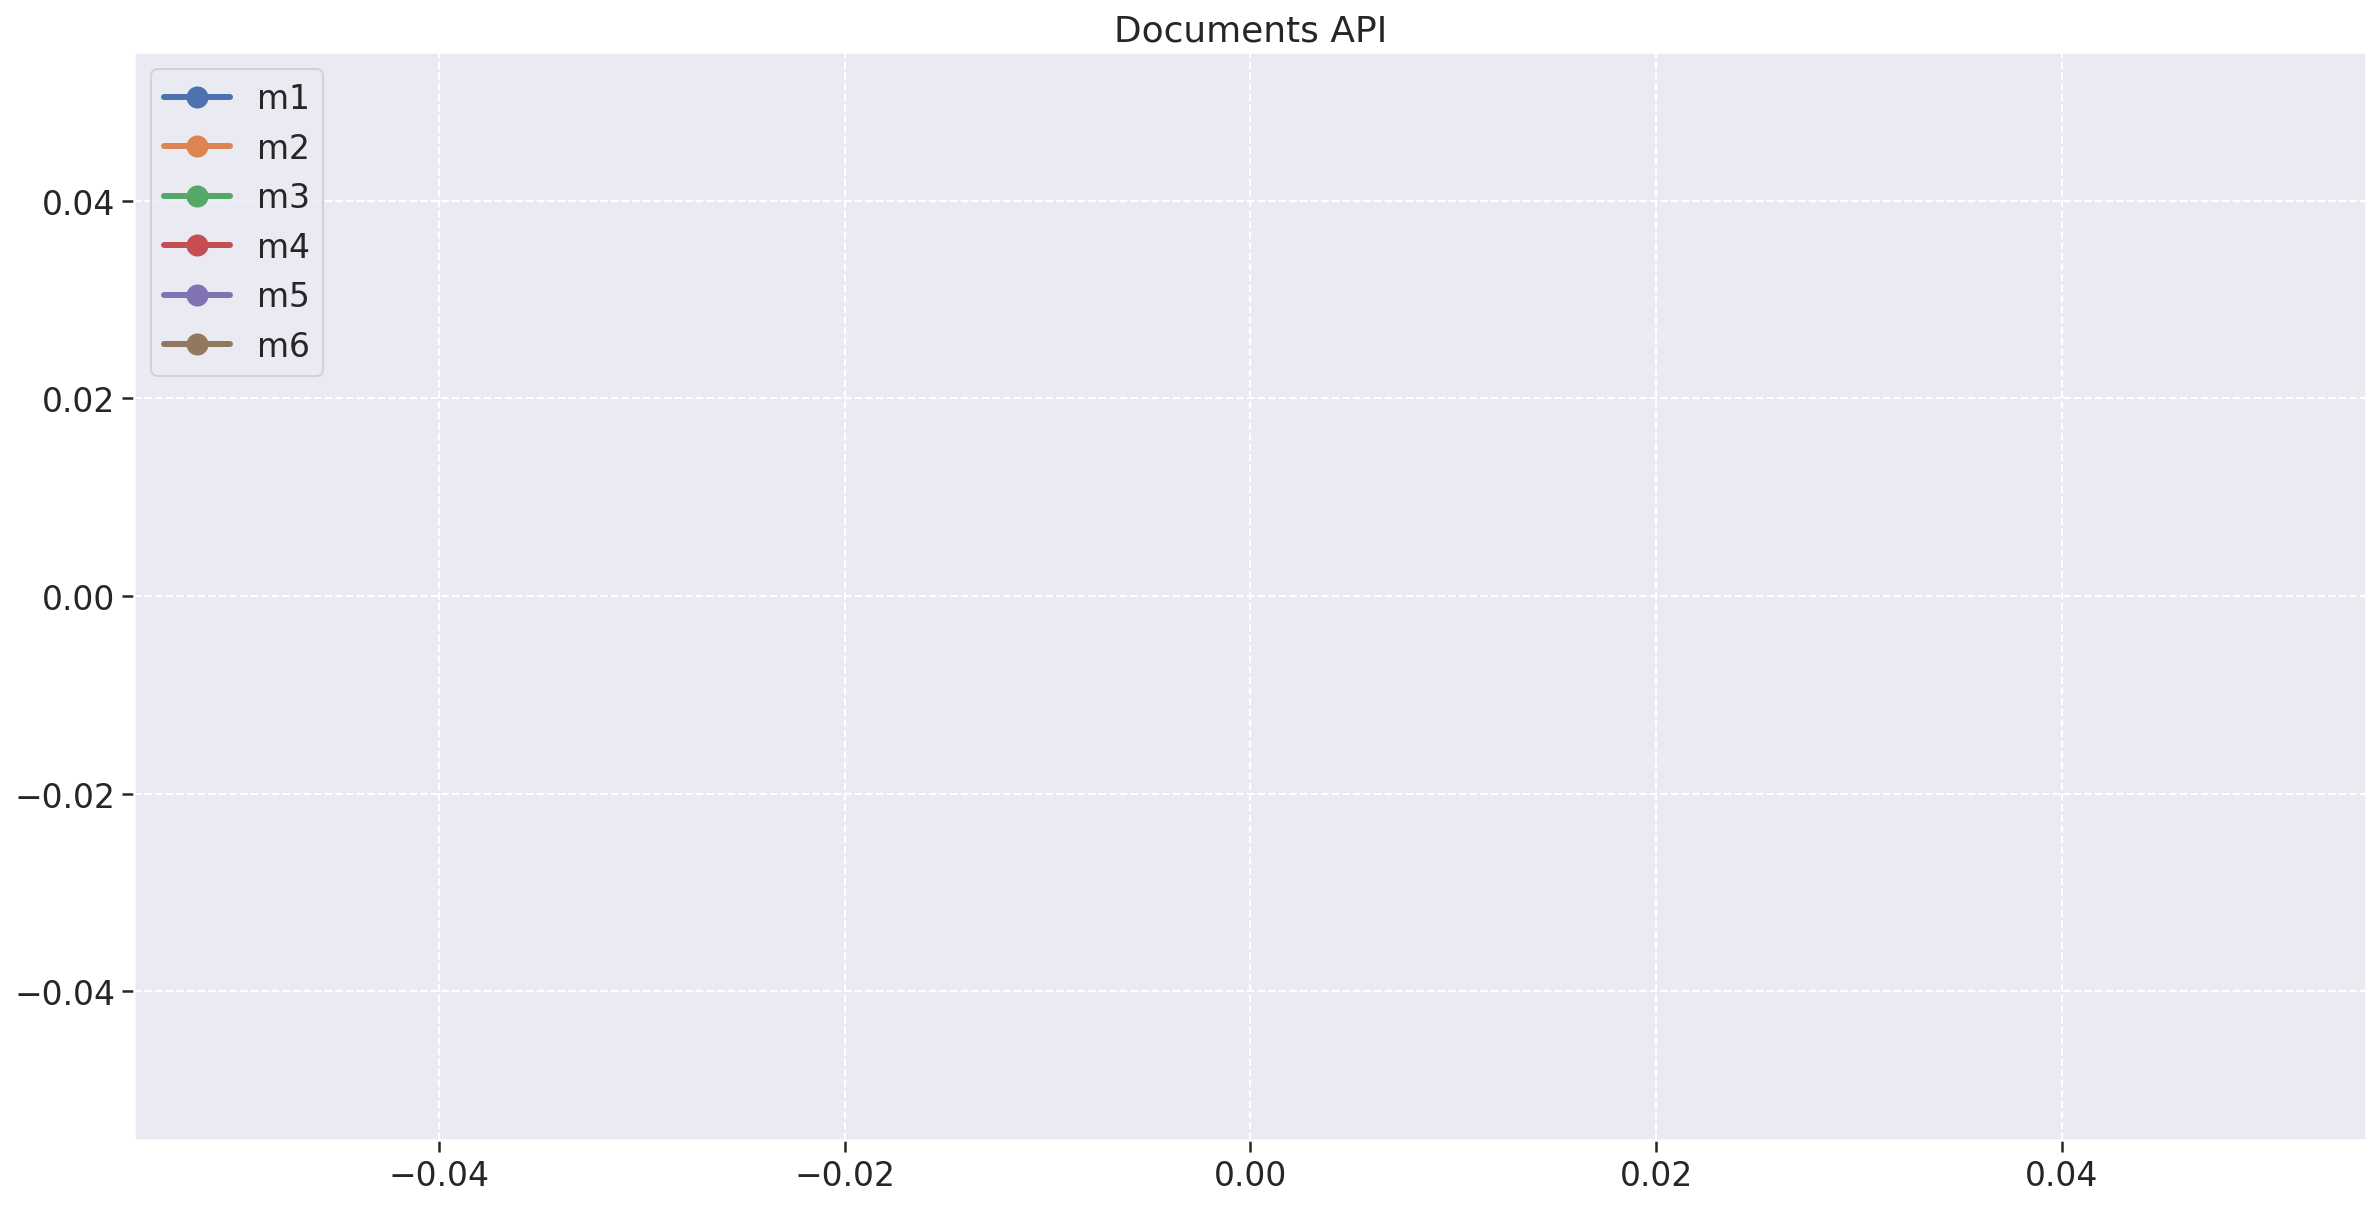

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.title('Documents API')
plt.plot(documentsapi_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(documentsapi_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(documentsapi_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(documentsapi_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(documentsapi_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(documentsapi_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

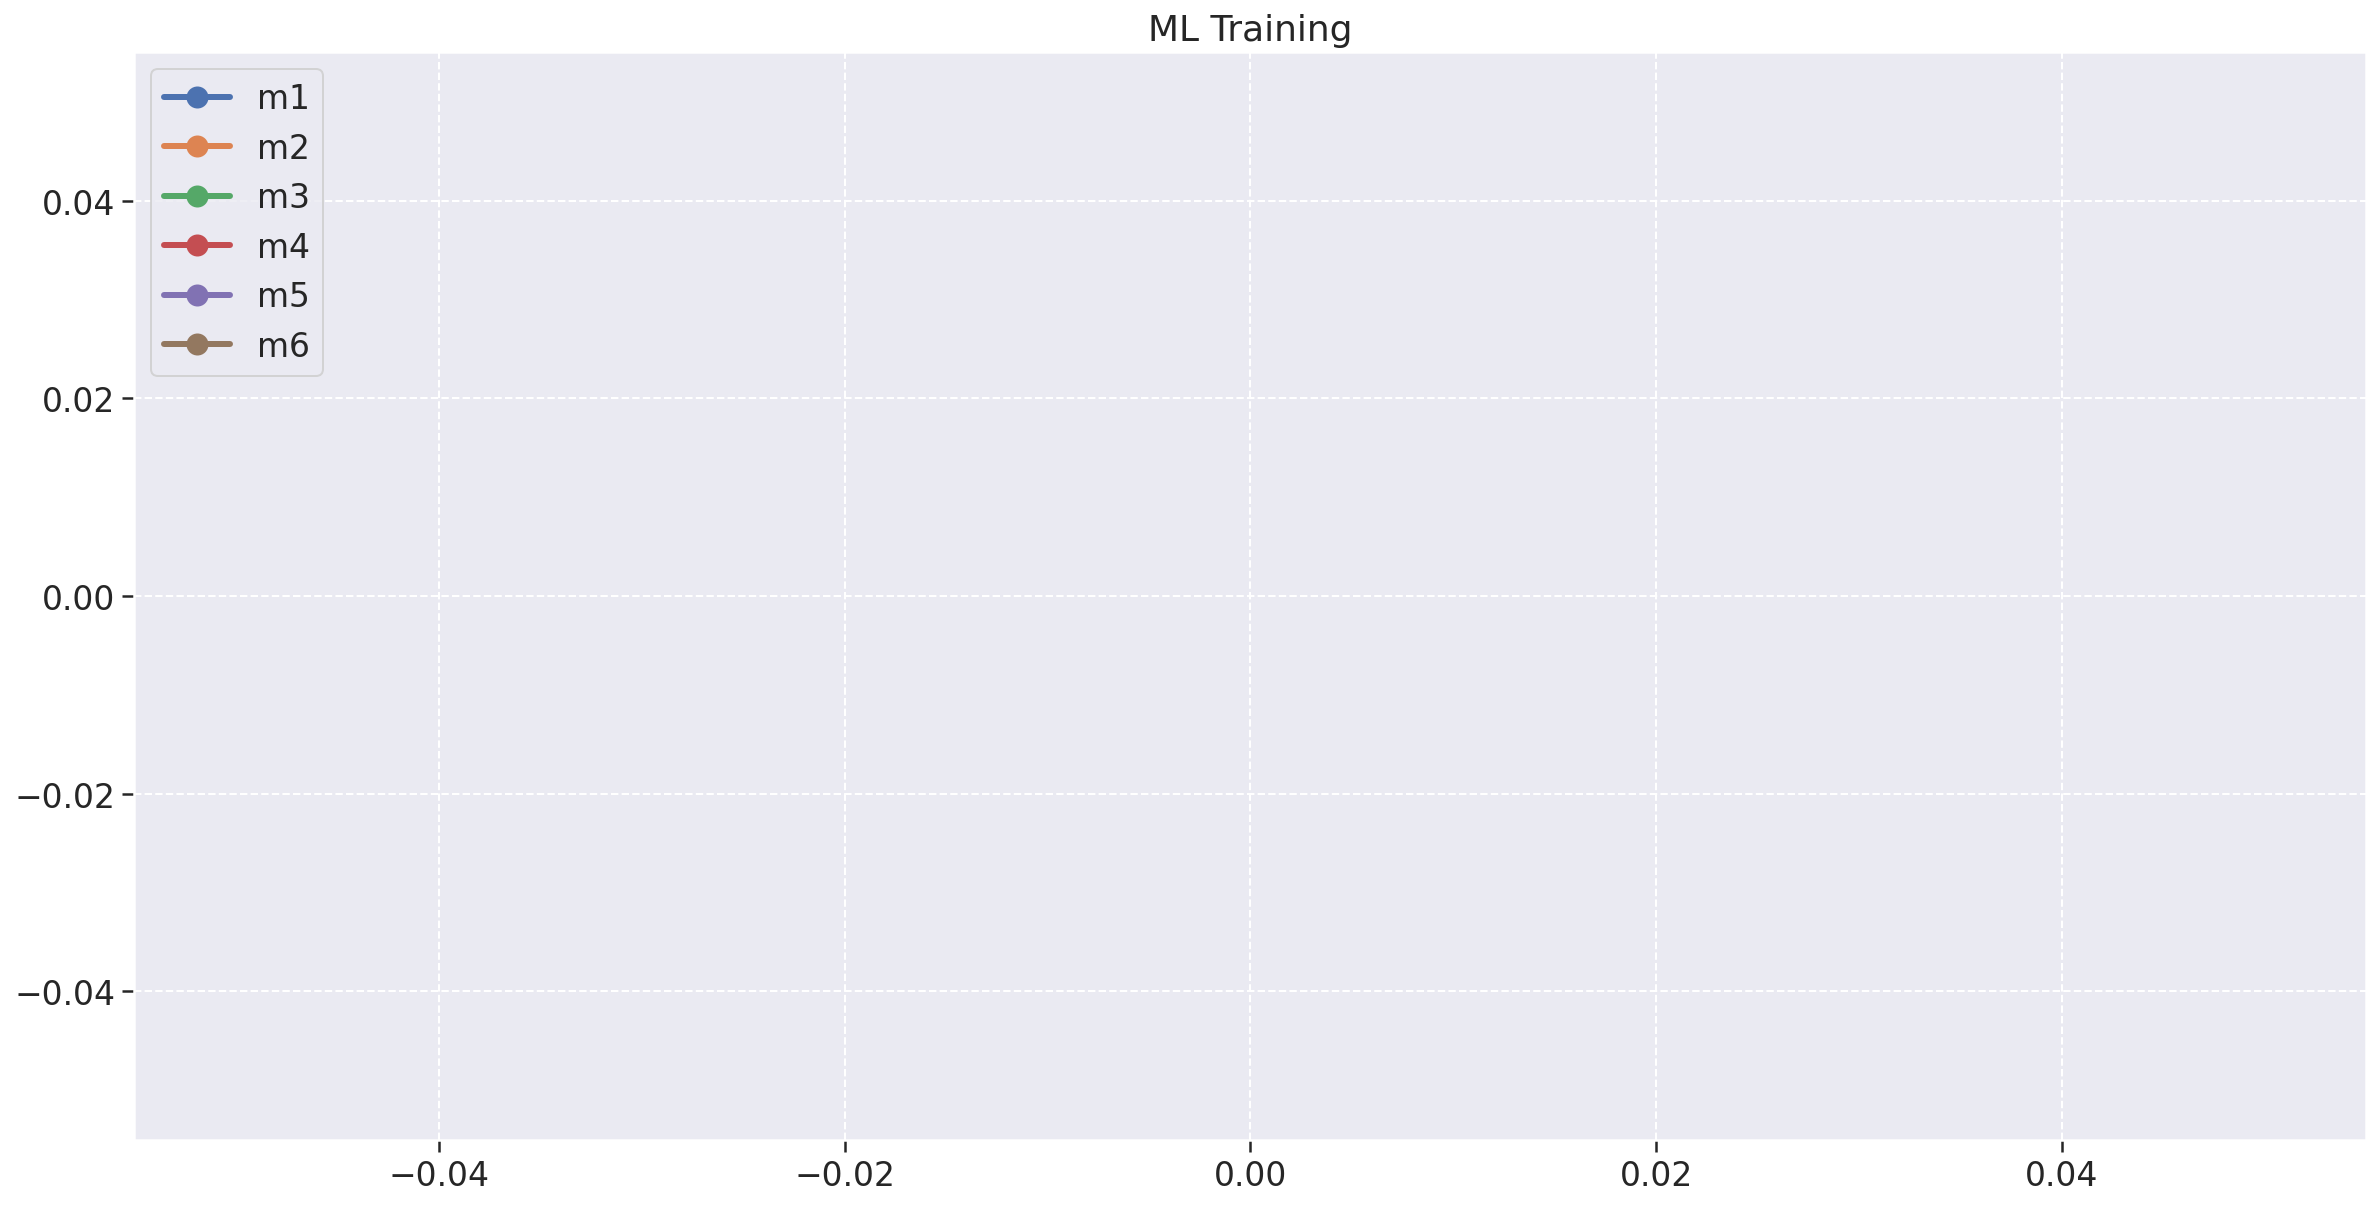

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training')
plt.plot(mltraining_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(mltraining_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(mltraining_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(mltraining_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(mltraining_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(mltraining_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

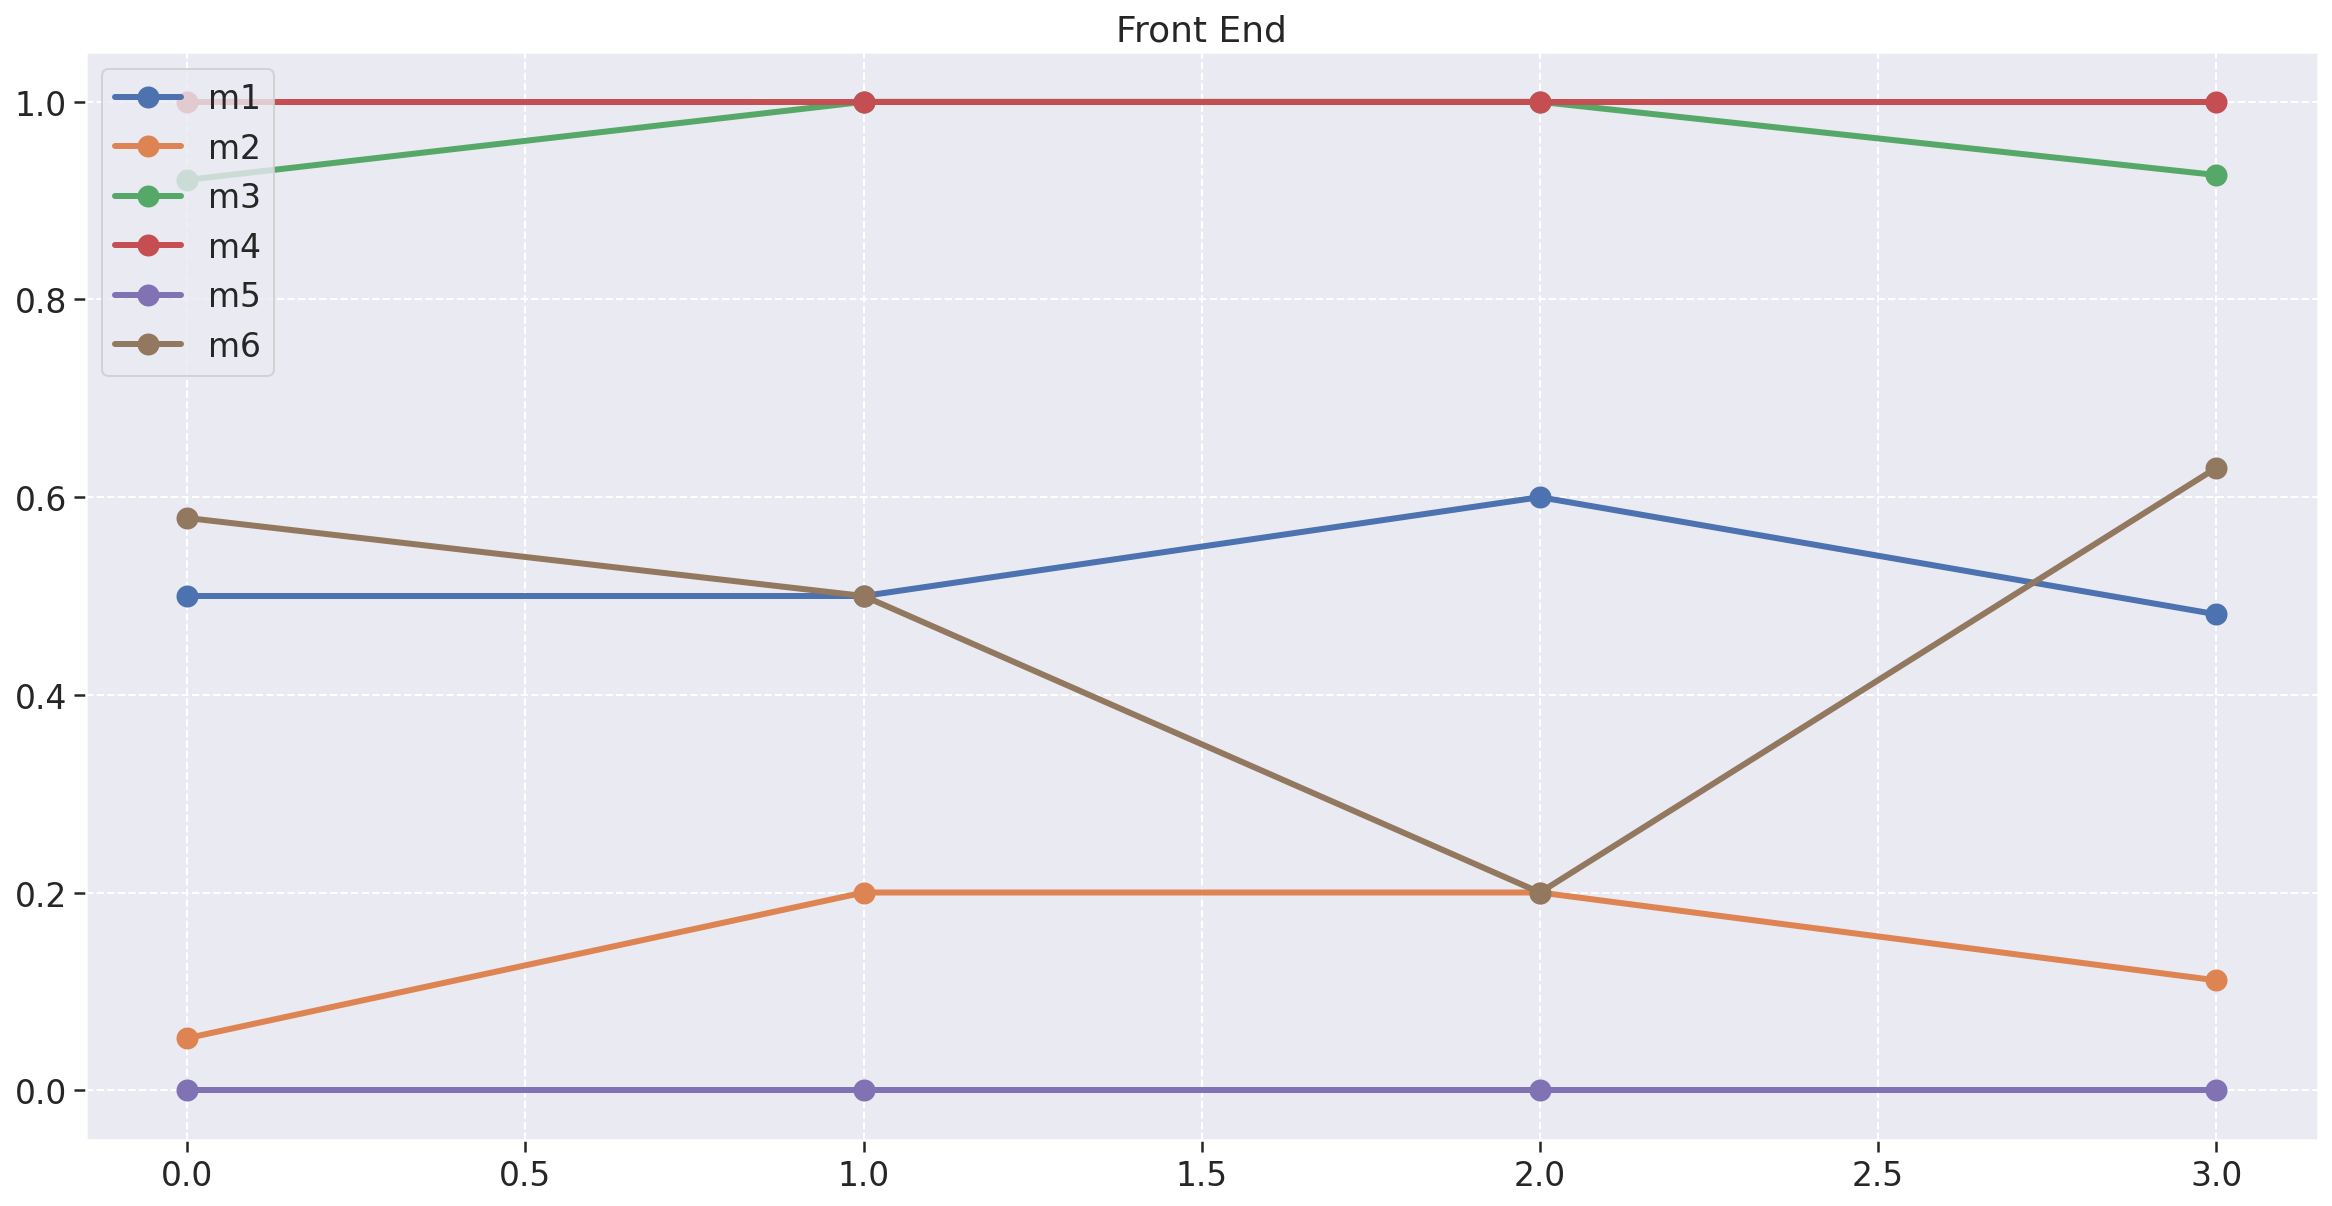

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End')
plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(frontend_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(frontend_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(frontend_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### Sub characteristic aggregation

- You must do this for each of your repositories

In [26]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

scraper_metrics['code_quality'] = ((scraper_metrics['m1']*pm1) + (scraper_metrics['m2']*pm2) + (scraper_metrics['m3']*pm3)) * psc1
documentsapi_metrics['code_quality'] = ((documentsapi_metrics['m1']*pm1) + (documentsapi_metrics['m2']*pm2) + (documentsapi_metrics['m3']*pm3)) * psc1
mltraining_metrics['code_quality'] = ((mltraining_metrics['m1']*pm1) + (mltraining_metrics['m2']*pm2) + (mltraining_metrics['m3']*pm3)) * psc1
frontend_metrics['code_quality'] = ((frontend_metrics['m1']*pm1) + (frontend_metrics['m2']*pm2) + (frontend_metrics['m3']*pm3)) * psc1

scraper_metrics['testing_status'] = ((scraper_metrics['m4']*pm4) + (scraper_metrics['m5']*pm5) + (scraper_metrics['m6']*pm6)) * psc2
documentsapi_metrics['testing_status'] = ((documentsapi_metrics['m4']*pm4) + (documentsapi_metrics['m5']*pm5) + (documentsapi_metrics['m6']*pm6)) * psc2
mltraining_metrics['testing_status'] = ((mltraining_metrics['m4']*pm4) + (mltraining_metrics['m5']*pm5) + (mltraining_metrics['m6']*pm6)) * psc2
frontend_metrics['testing_status'] = ((frontend_metrics['m4']*pm4) + (frontend_metrics['m5']*pm5) + (frontend_metrics['m6']*pm6)) * psc2

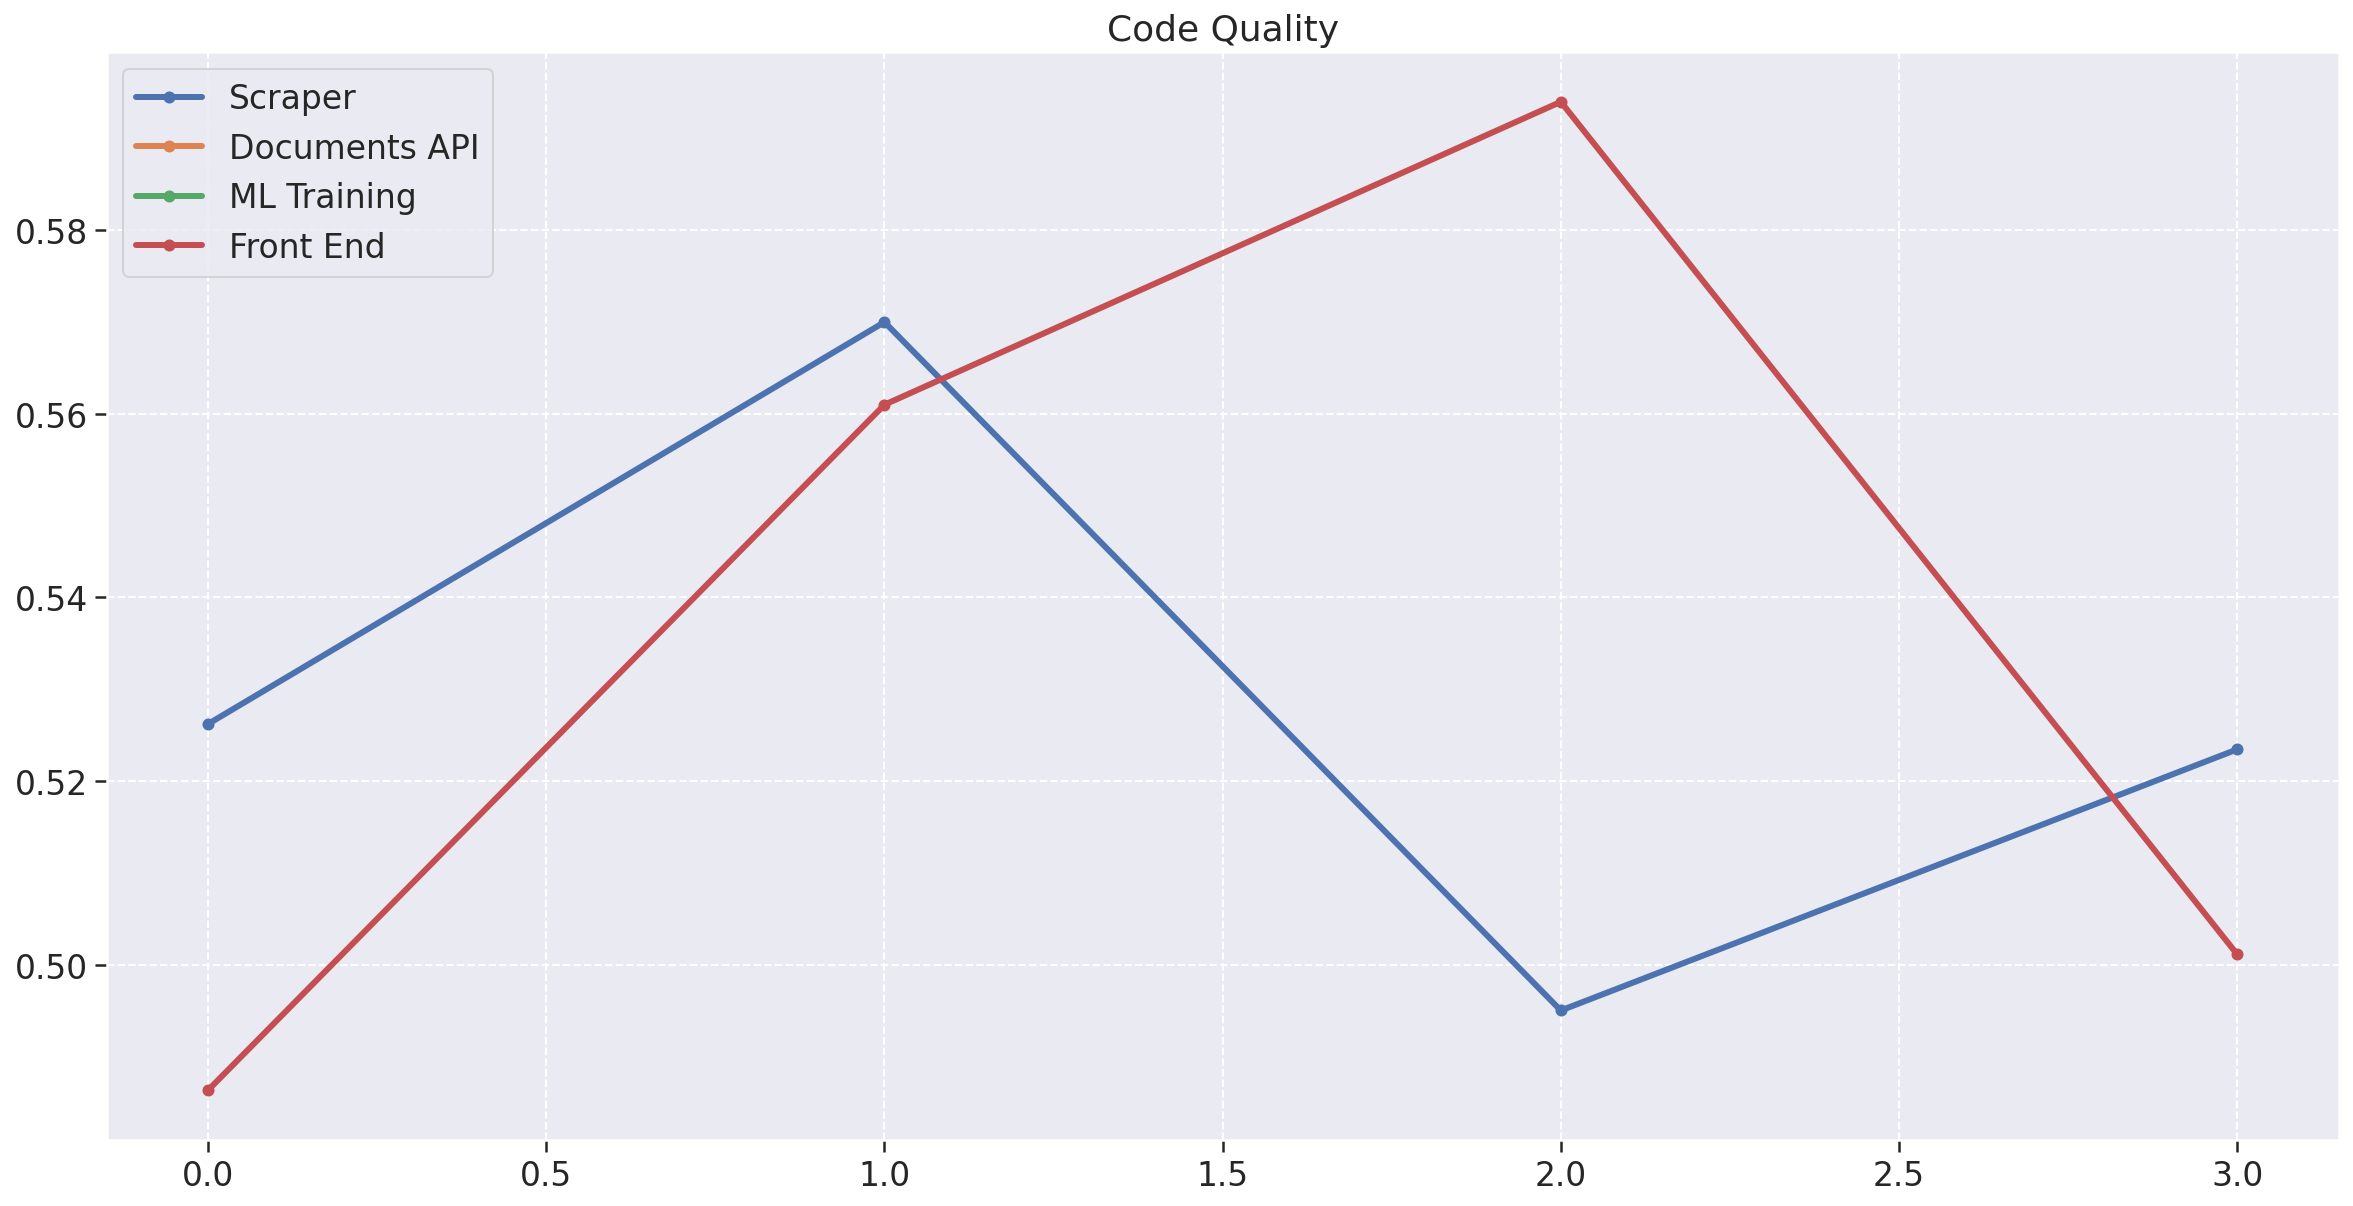

In [27]:
fig = plt.figure(figsize=(20, 10))


plt.title('Code Quality')
plt.plot(scraper_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Scraper')
plt.plot(documentsapi_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Documents API')
plt.plot(mltraining_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='ML Training')
plt.plot(frontend_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Front End')

plt.legend(loc='upper left')

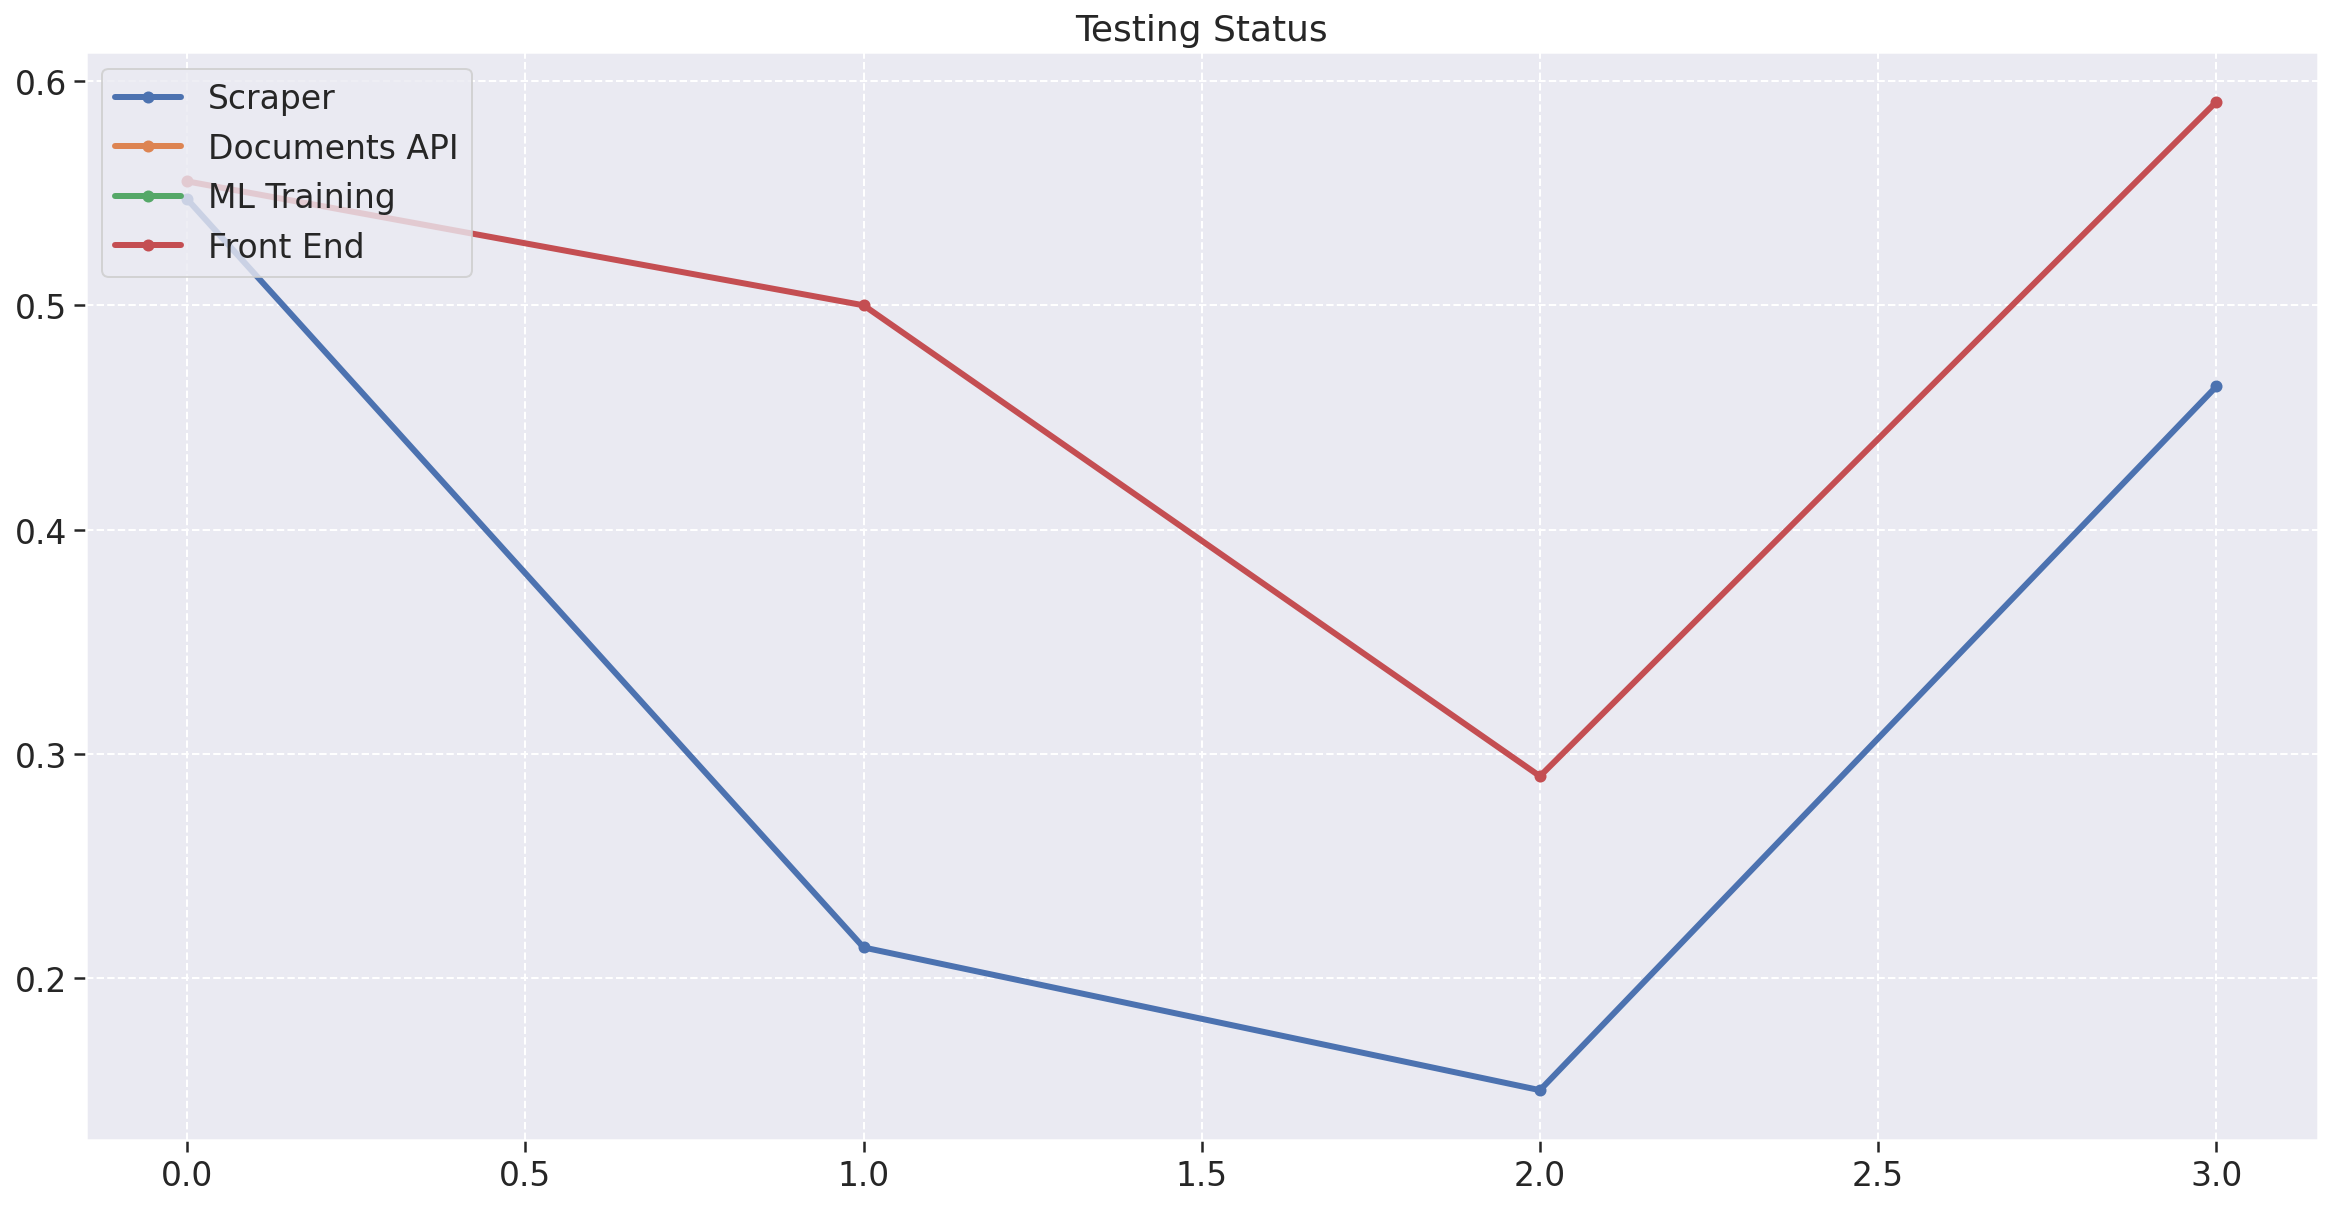

In [28]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(scraper_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Scraper')
plt.plot(documentsapi_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Documents API')
plt.plot(mltraining_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='ML Training')
plt.plot(frontend_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Front End')

plt.legend(loc='upper left')

## Descriptive Statistics

### Scraper

In [29]:
scraper_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.432432,0.162162,1.0,1.0,0,0.567568,Scraper,02-11-2021-23-26,1348,0.526216,0.547297
1,0.636364,0.090909,1.0,1.0,0,0.090909,Scraper,07-10-2021-07-43,484,0.570000,0.213636
2,0.500000,0.000000,1.0,1.0,0,0.000000,Scraper,15-09-2021-00-01,138,0.495000,0.150000
3,0.482759,0.103448,1.0,1.0,0,0.448276,Scraper,21-10-2021-15-11,1058,0.523448,0.463793


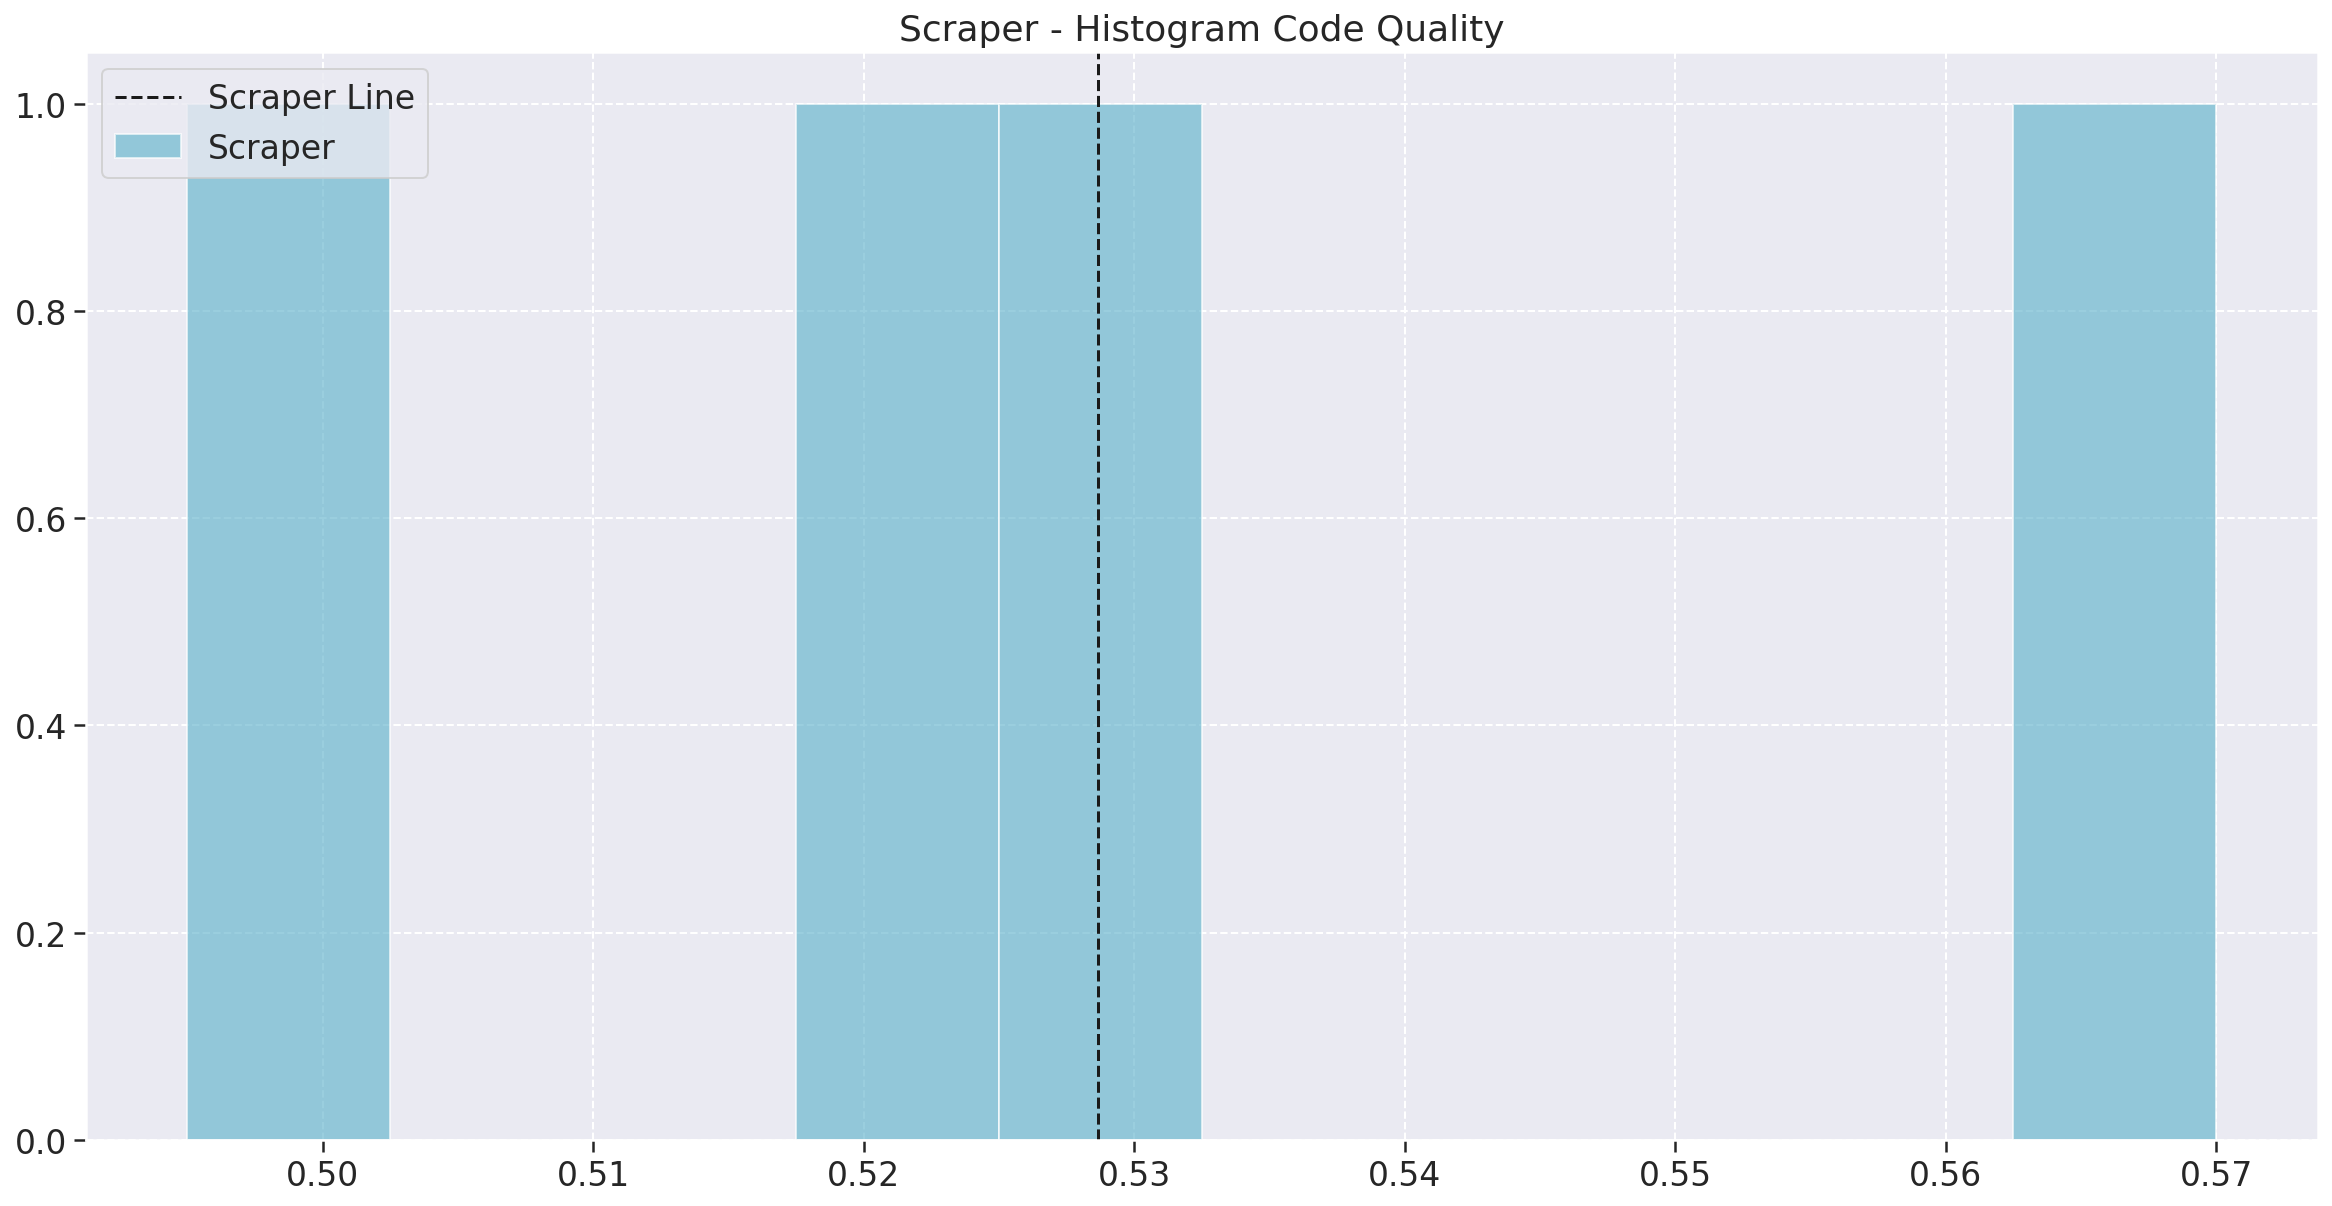

In [30]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Histogram Code Quality')
plt.hist(scraper_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Scraper')
plt.axvline(scraper_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Scraper Line')

plt.legend(loc='upper left')

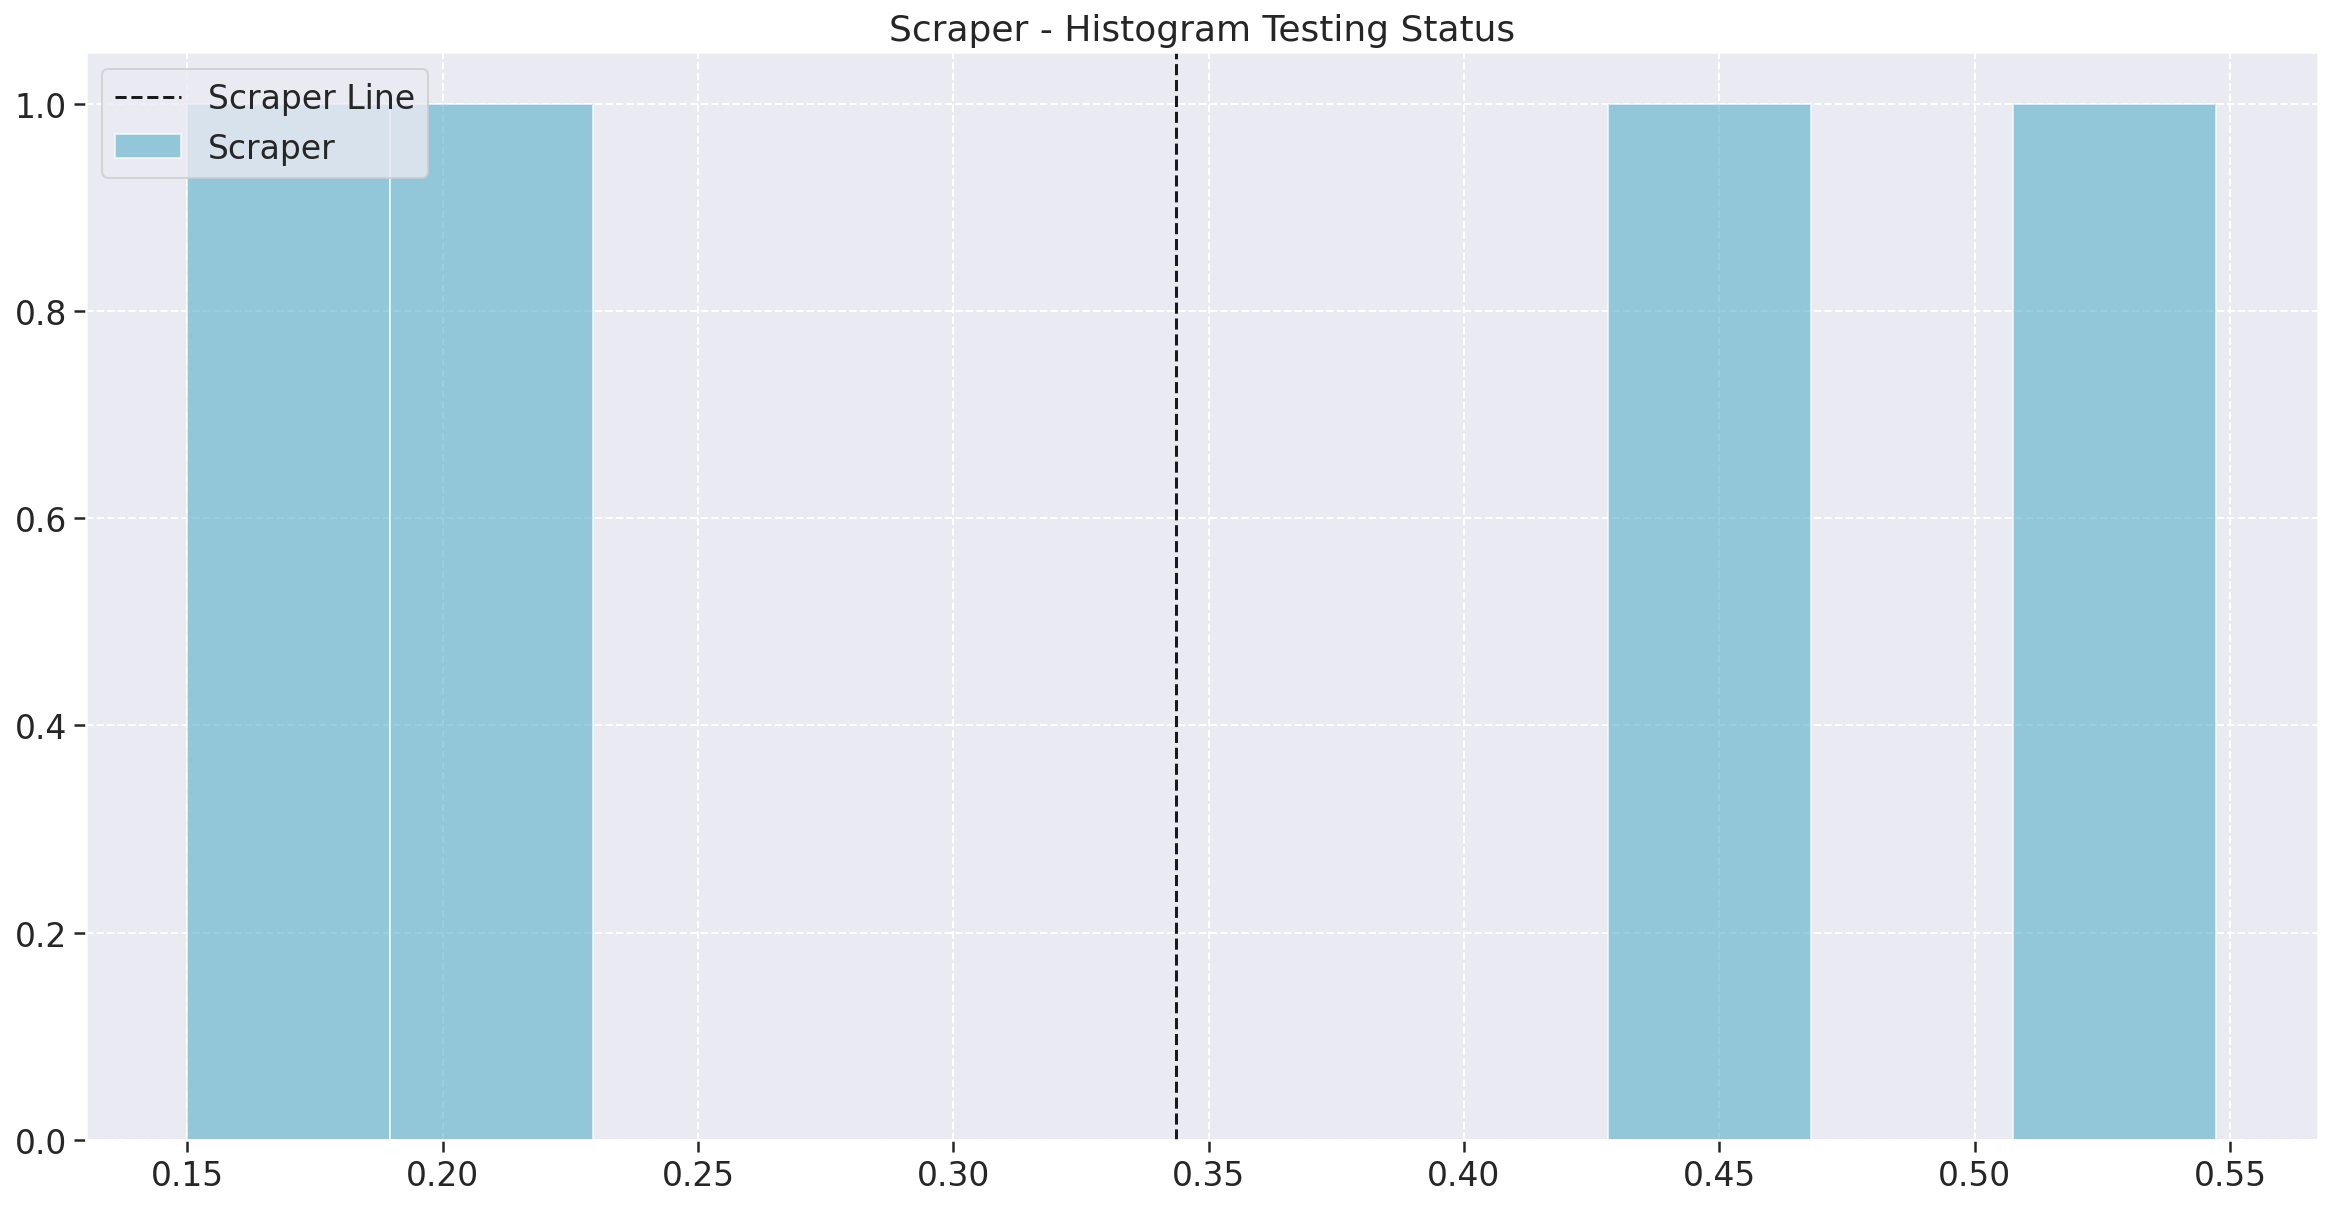

In [31]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Histogram Testing Status')
plt.hist(scraper_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Scraper')
plt.axvline(scraper_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Scraper Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2b77a2c9a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2b77a36100>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2b77a2c610>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2b77a36820>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2b77a36bb0>],
 'means': []}

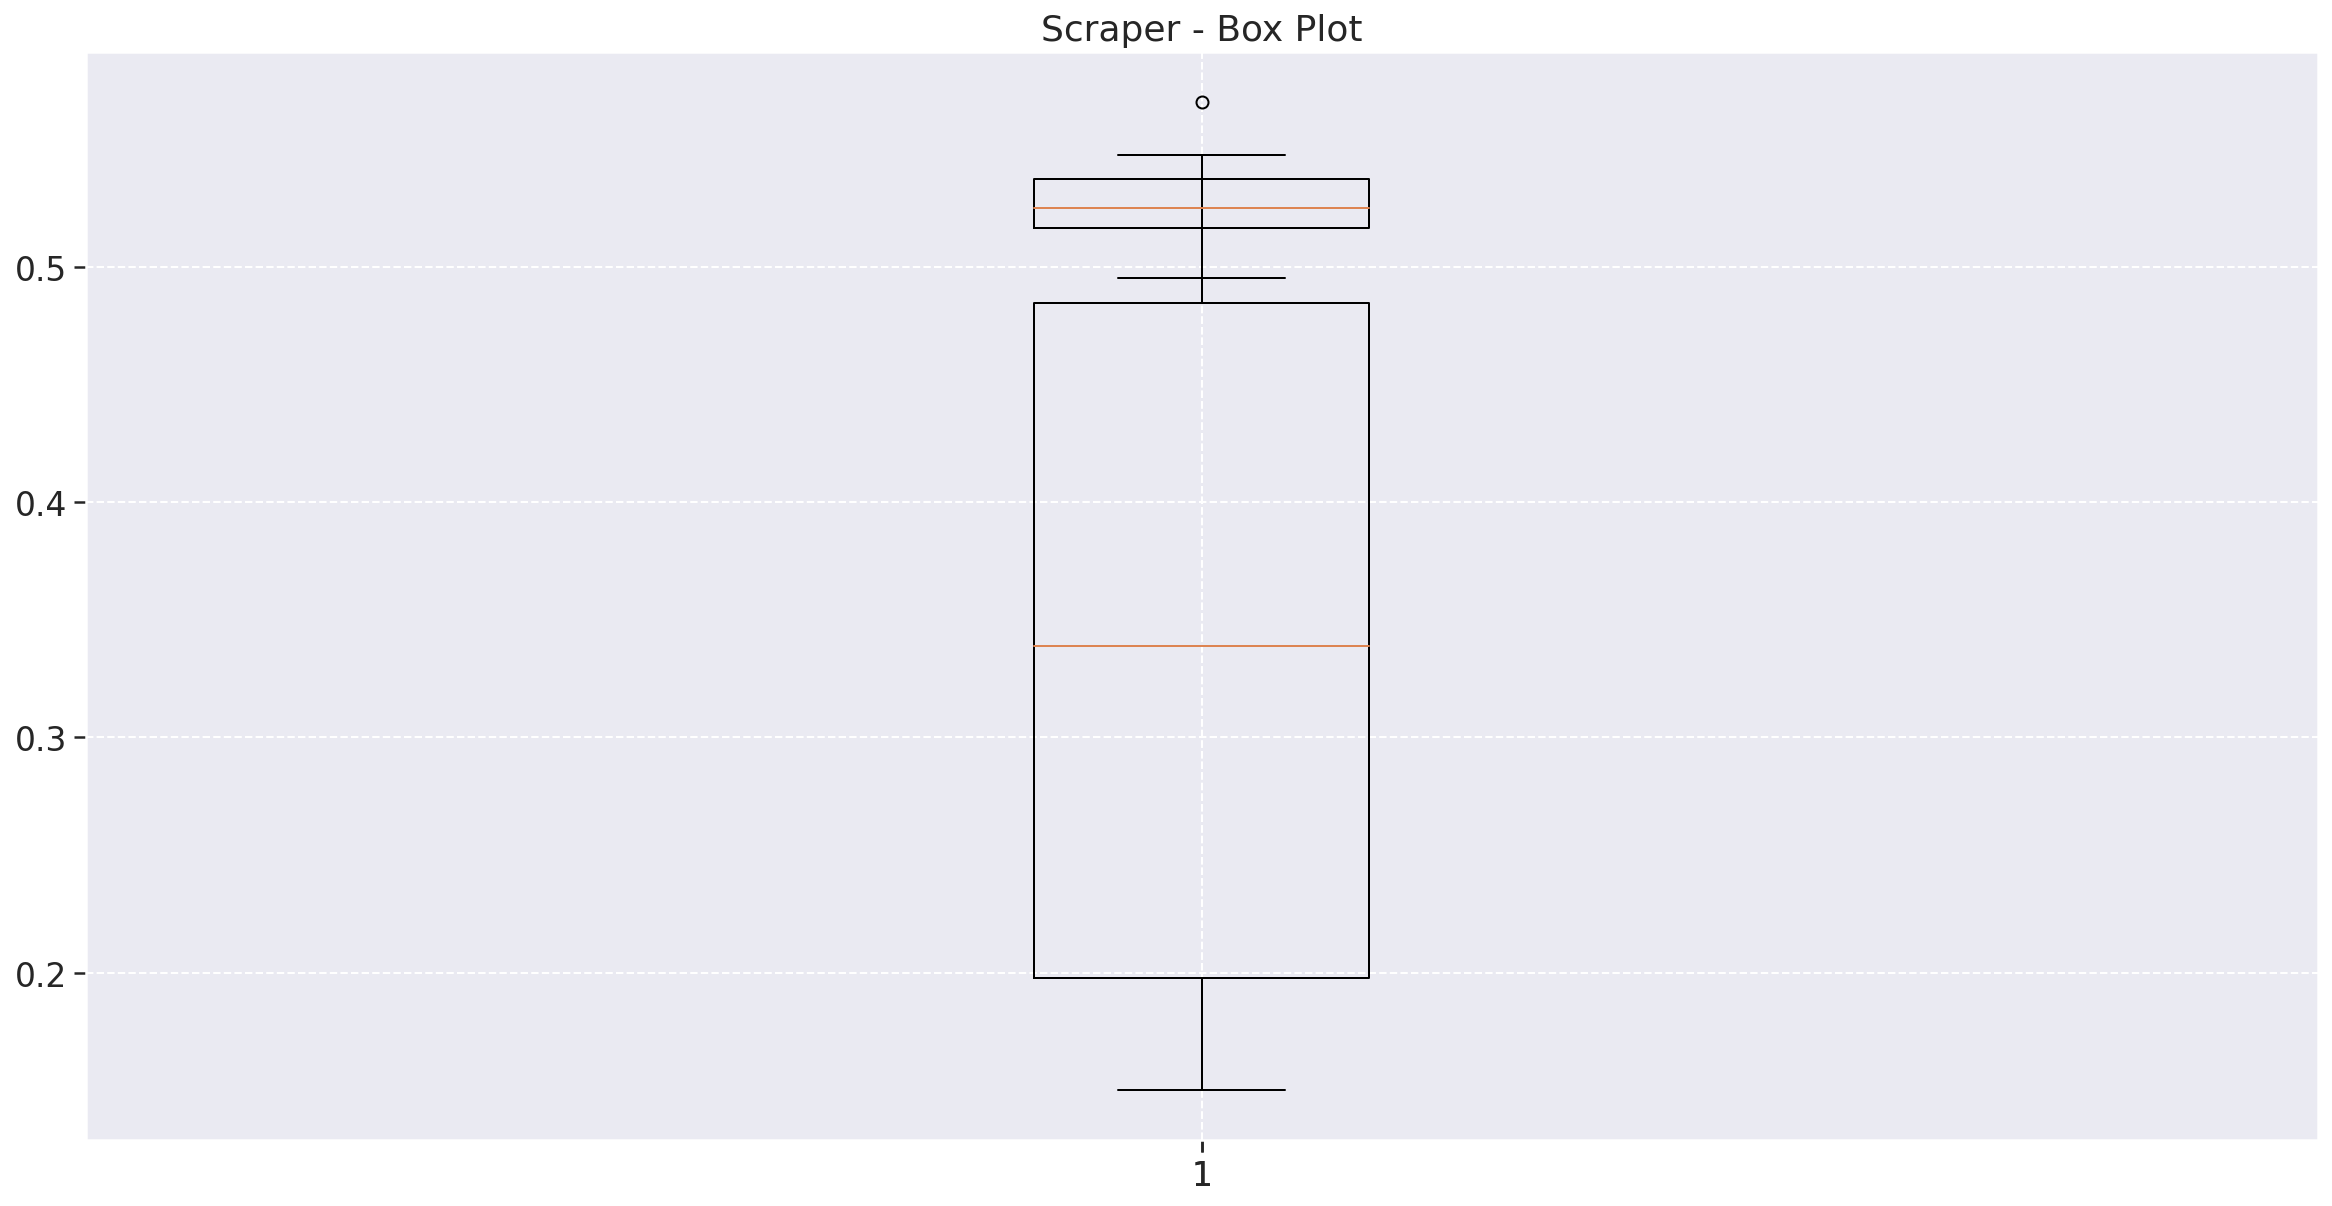

In [32]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Box Plot')
plt.boxplot(scraper_metrics['code_quality'])
plt.boxplot(scraper_metrics['testing_status'])

In [33]:
metrics_df = pd.concat([scraper_metrics, documentsapi_metrics, mltraining_metrics, frontend_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [34]:
def create_descriptive_df(df):
    maintainability_df = df['maintainability']
    reliability_df = df['Reliability']
    
    descriptive_df = pd.DataFrame(
                columns=['Maintainability', 'Reliability'])
    
    descriptive_df.loc['mean'] = [maintainability_df.mean() * 100, reliability_df.mean()* 100]
    descriptive_df.loc['mode'] = [maintainability_df.mode().max()* 100, reliability_df.mode().max()* 100]
    descriptive_df.loc['25%'] = [maintainability_df.quantile(0.25)* 100, reliability_df.quantile(0.25)* 100]
    descriptive_df.loc['50%'] = [maintainability_df.quantile(0.50)* 100, reliability_df.quantile(0.50)* 100]
    descriptive_df.loc['75%'] = [maintainability_df.quantile(0.75)* 100, reliability_df.quantile(0.75)* 100]
    descriptive_df.loc['standart_deviation'] = [maintainability_df.std()* 100, reliability_df.std()* 100]
    descriptive_df.loc['variance'] = [maintainability_df.var()* 100, reliability_df.var()* 100]
    descriptive_df.loc['min'] = [maintainability_df.min()* 100, reliability_df.min()* 100]
    descriptive_df.loc['max'] = [maintainability_df.max()* 100, reliability_df.max()* 100]
    
    
    return descriptive_df

In [35]:
descriptive_df = create_descriptive_df(metrics_df)

In [36]:
descriptive_df

,Maintainability,Reliability
mean,26.606821,20.692067
mode,29.700000,29.537037
25%,24.979167,13.545455
50%,26.241612,24.094828
75%,28.162500,27.464438
standart_deviation,1.949872,8.536758
variance,0.038020,0.728762
min,24.315789,7.500000
max,29.700000,29.537037


Text(0.5, 1.0, 'Matriz de Correção - Maintainability e Reliability')

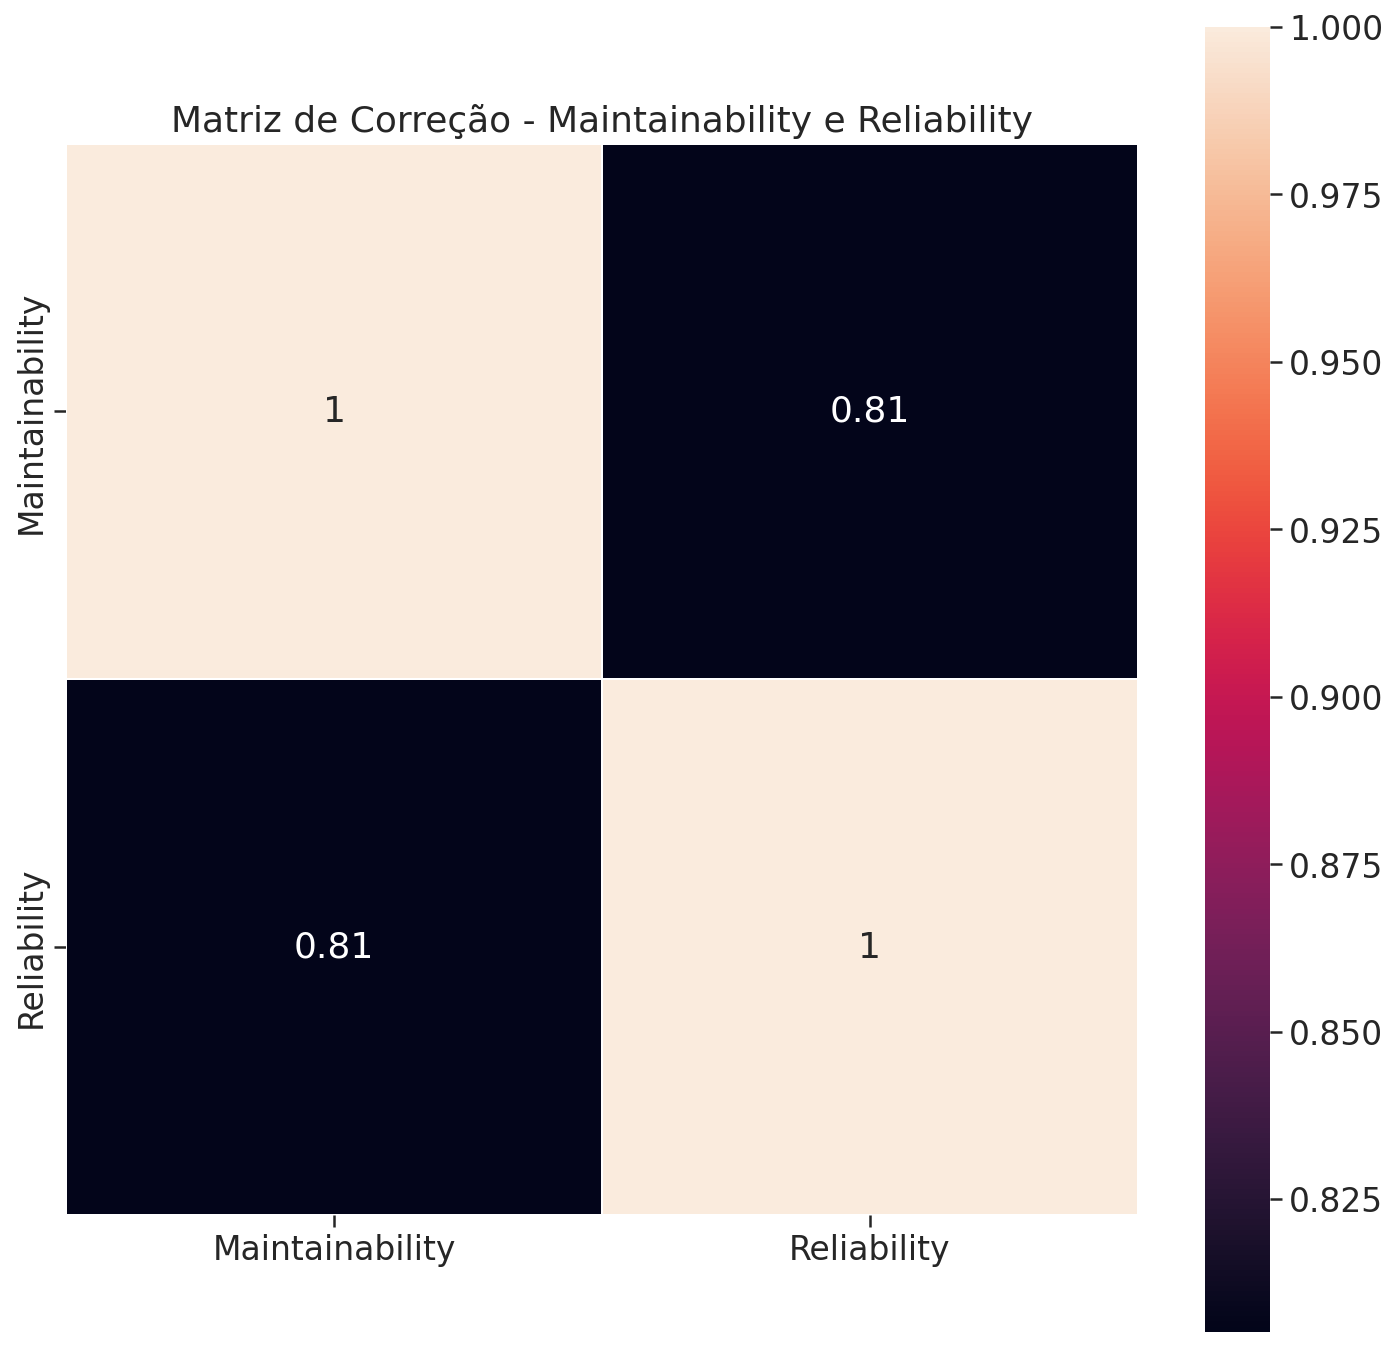

In [38]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(descriptive_df.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Maintainability e Reliability')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2b751e3e80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2b751f35e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2b751e3af0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2b751f3d00>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2b751820d0>,
 'means': []}

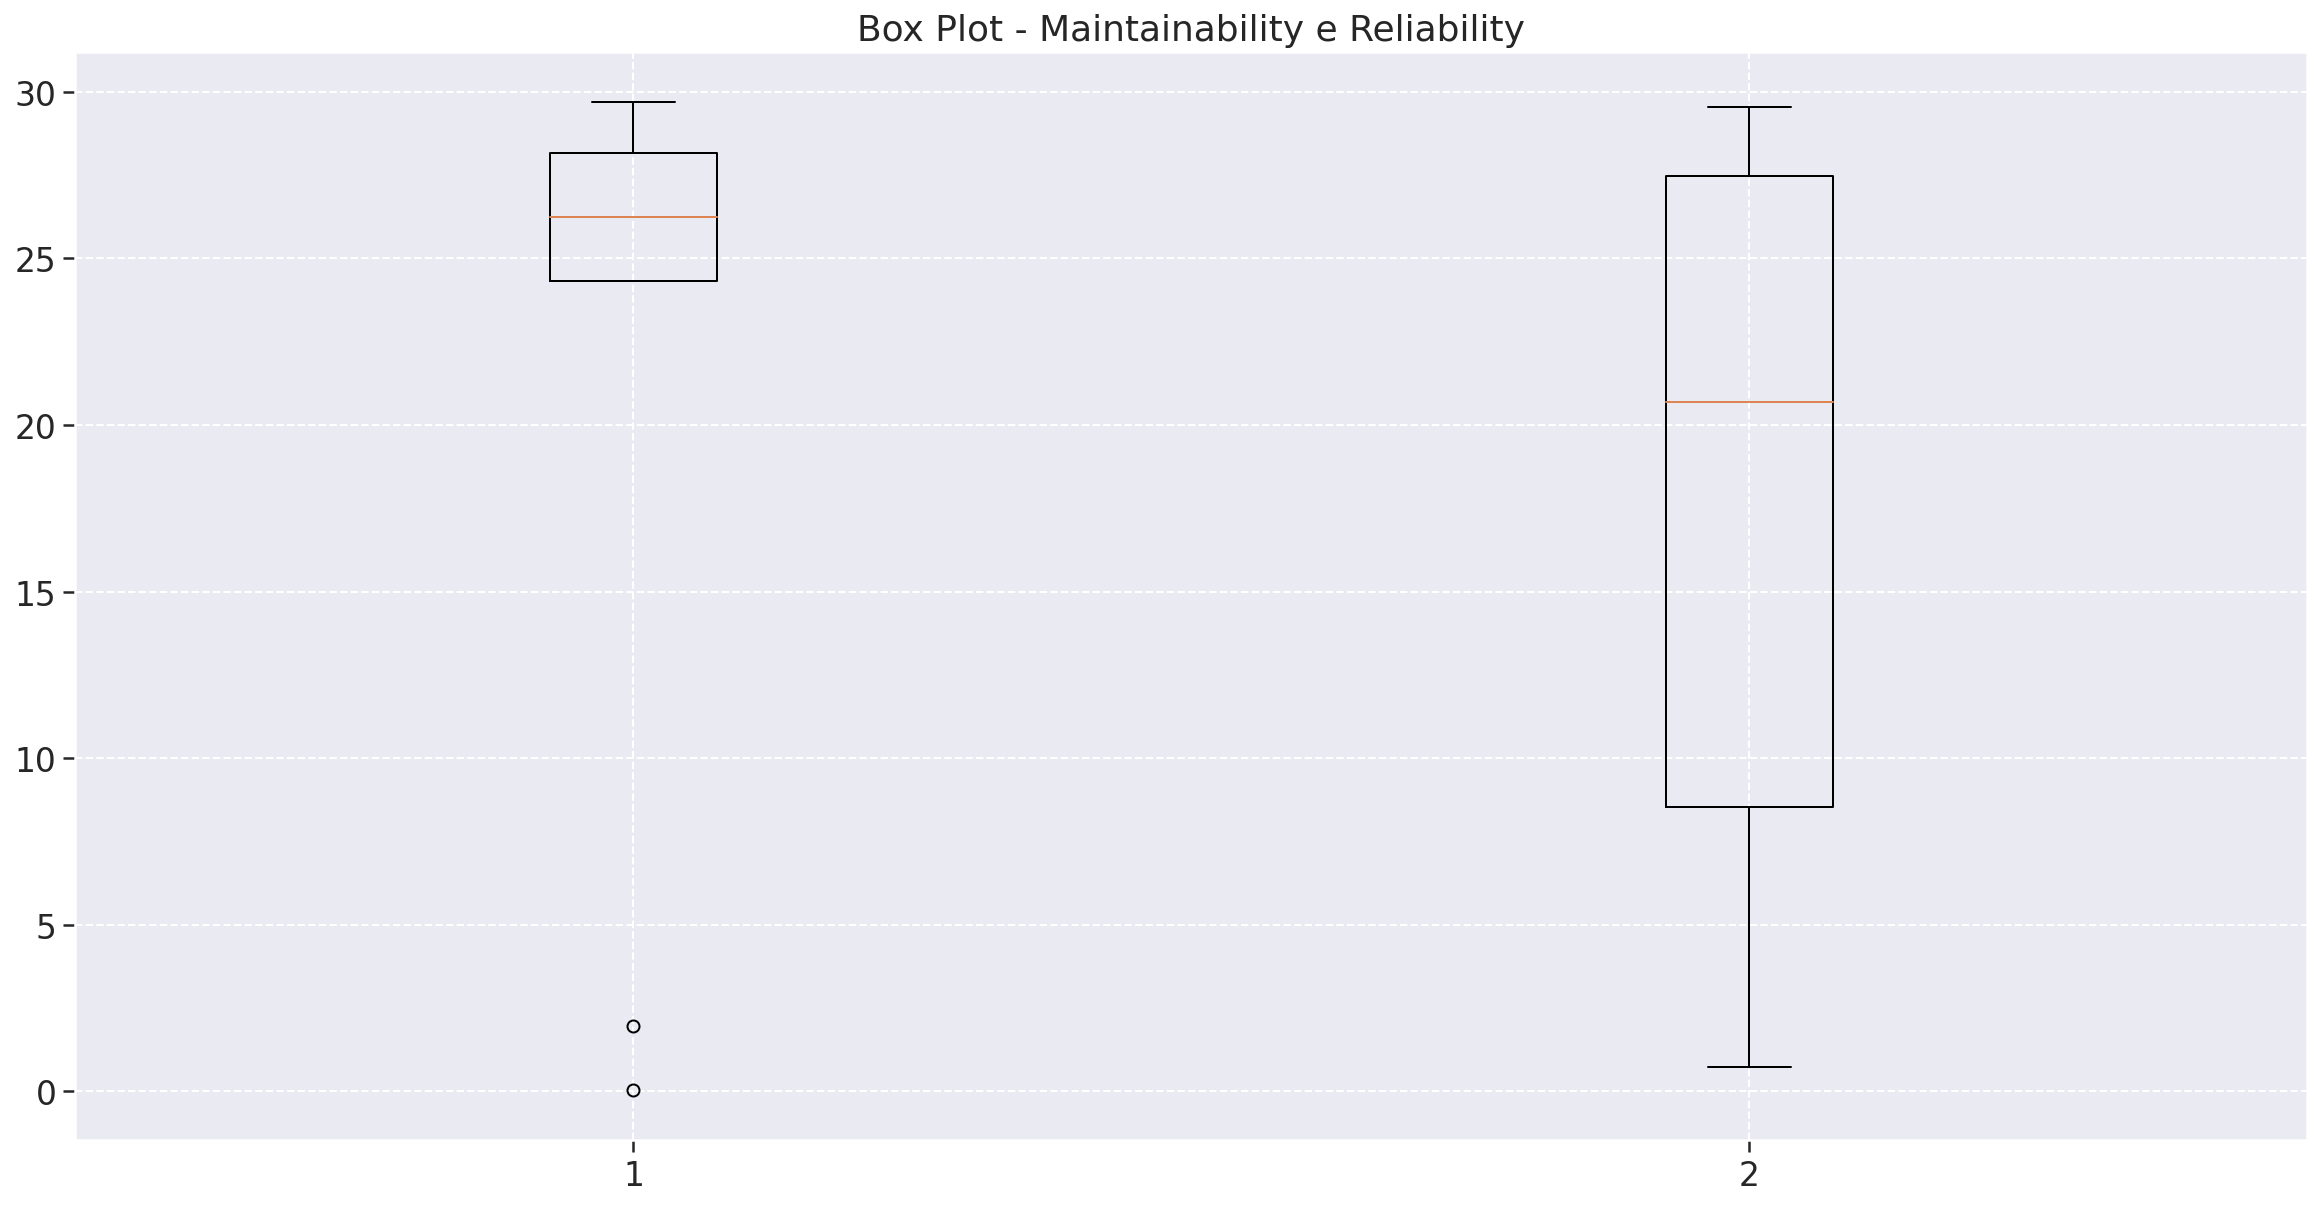

In [39]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Maintainability e Reliability')
plt.boxplot(descriptive_df)

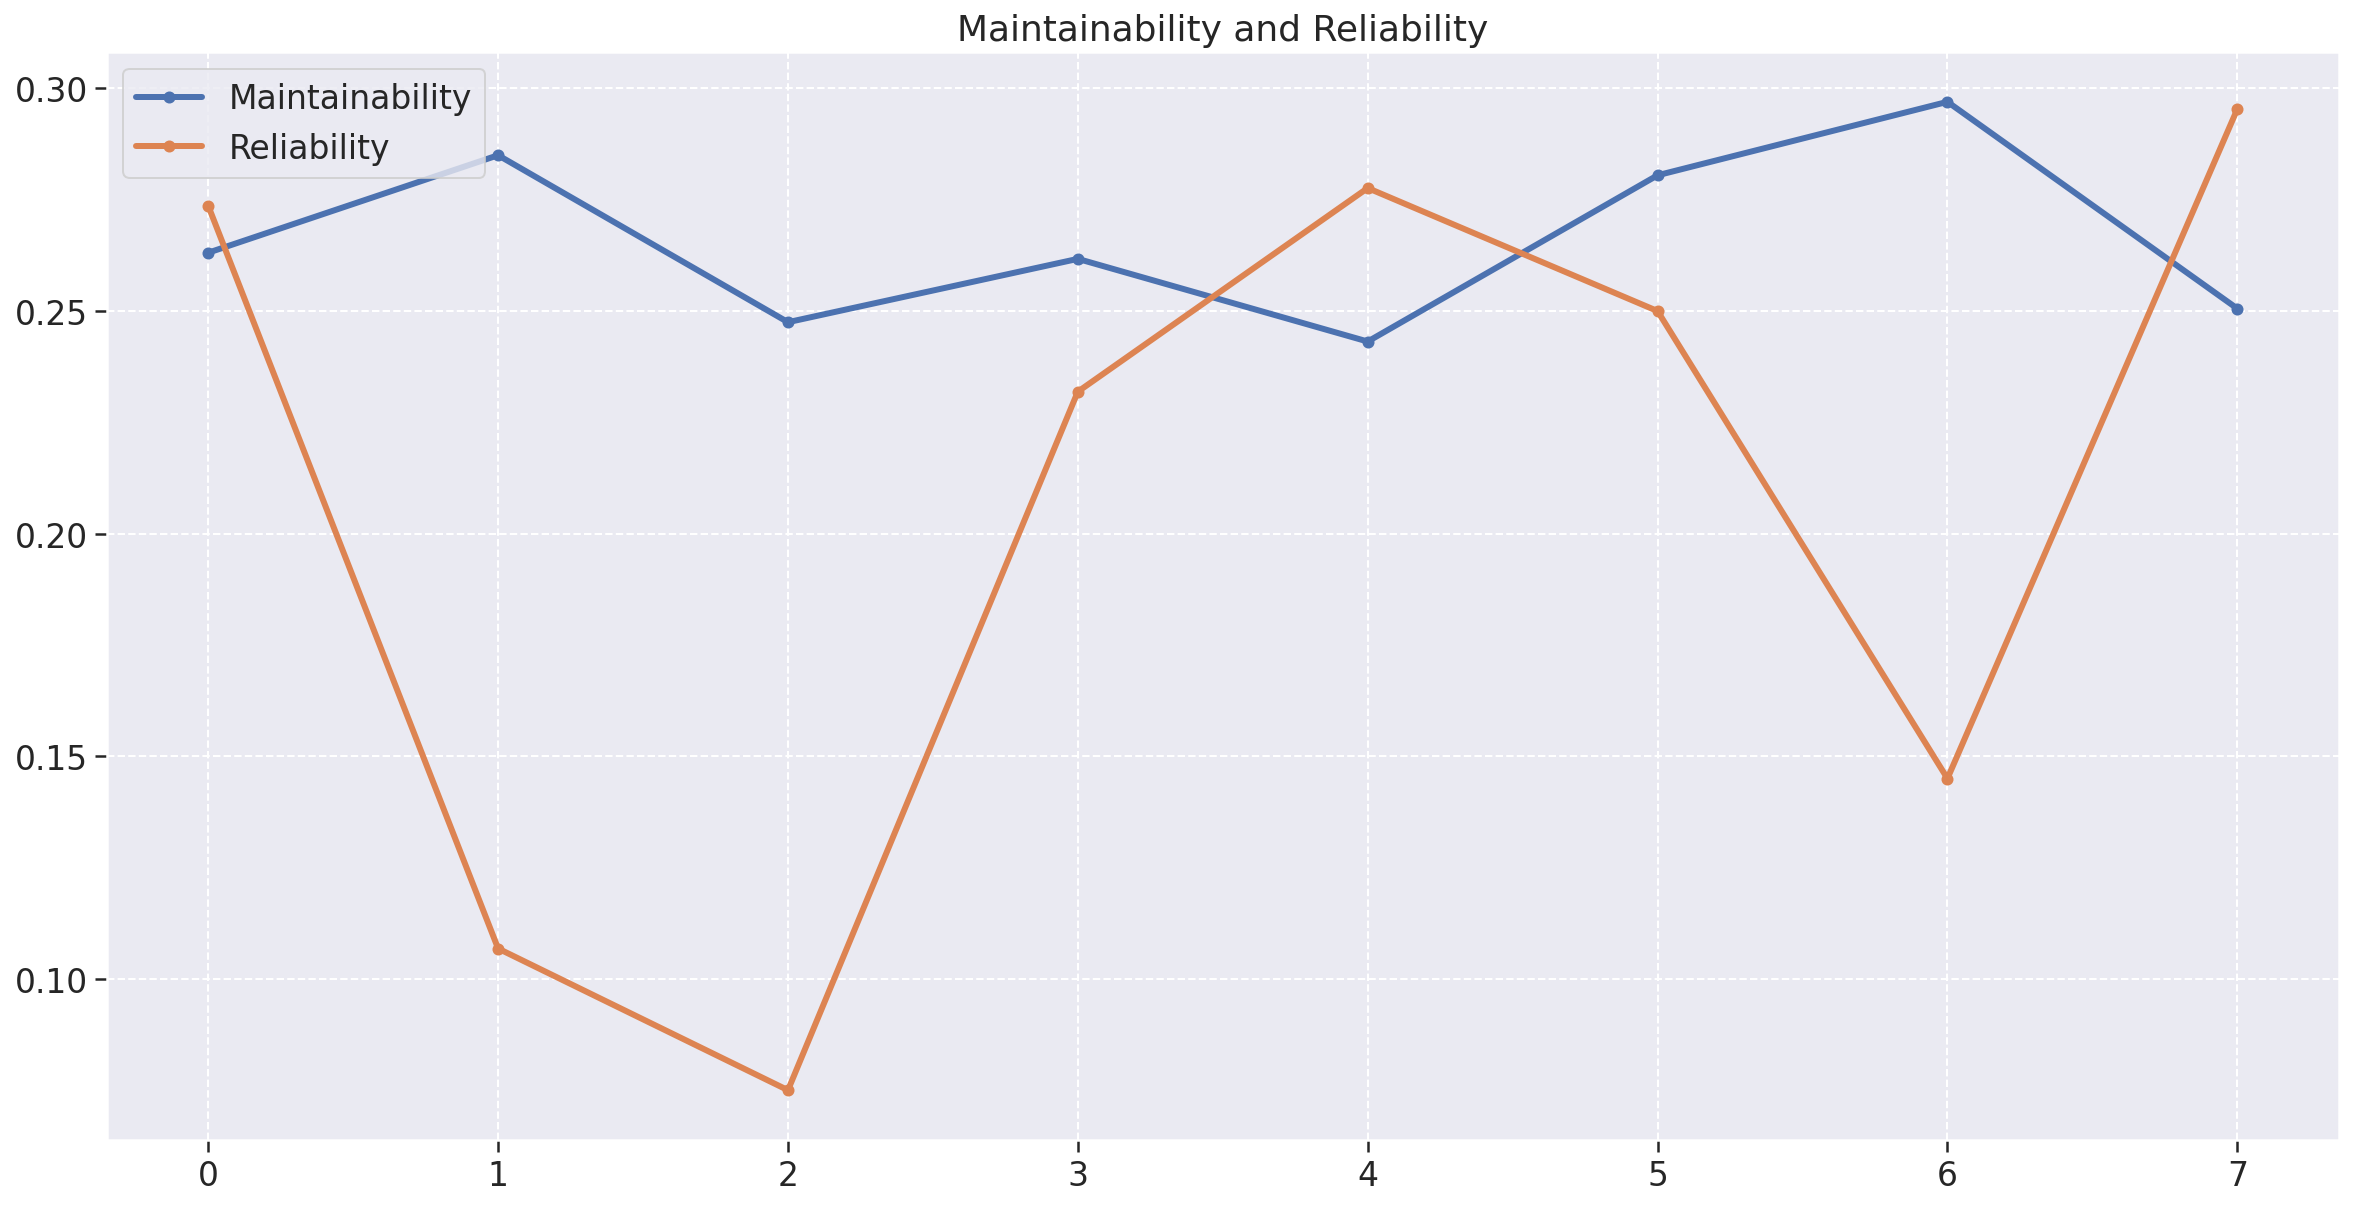

In [40]:
fig = plt.figure(figsize=(20, 10))

plt.title('Maintainability and Reliability')
plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5, label='Maintainability')
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5, label='Reliability')

#plt.ylim(.45,.7)
plt.legend(loc='upper left')


{'whiskers': [<matplotlib.lines.Line2D at 0x7f2b7505a5b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2b7505acd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2b7505a3a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2b75064430>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2b750647c0>],
 'means': []}

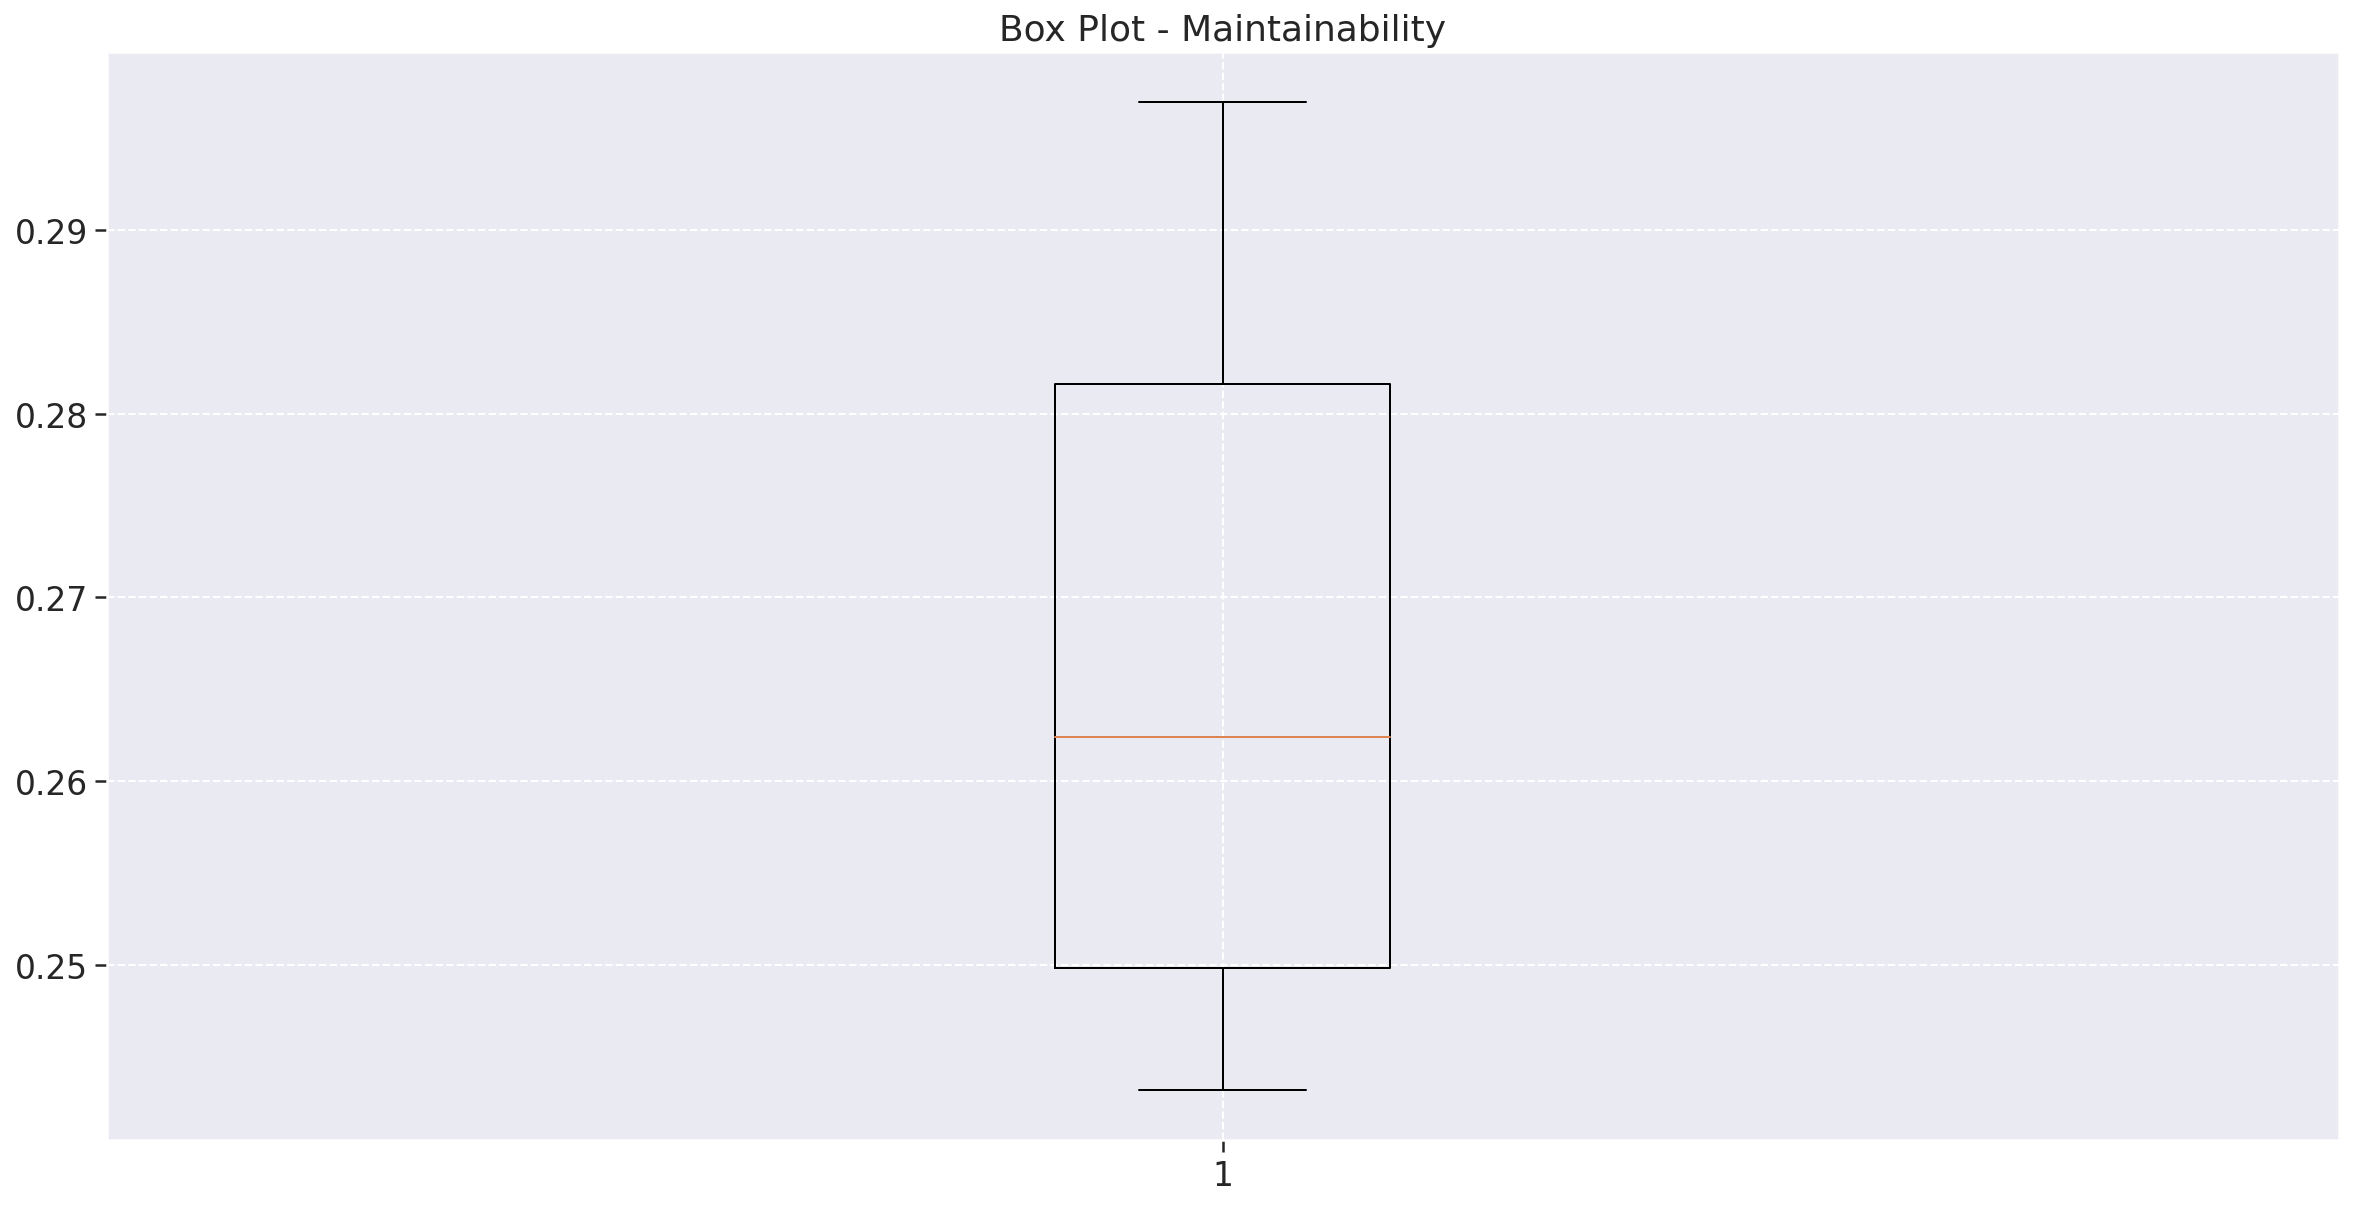

In [42]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Maintainability')
plt.boxplot(metrics_df['maintainability'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2b74fbabb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2b74fc8310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2b74fba820>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2b74fc8a30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2b74fc8dc0>],
 'means': []}

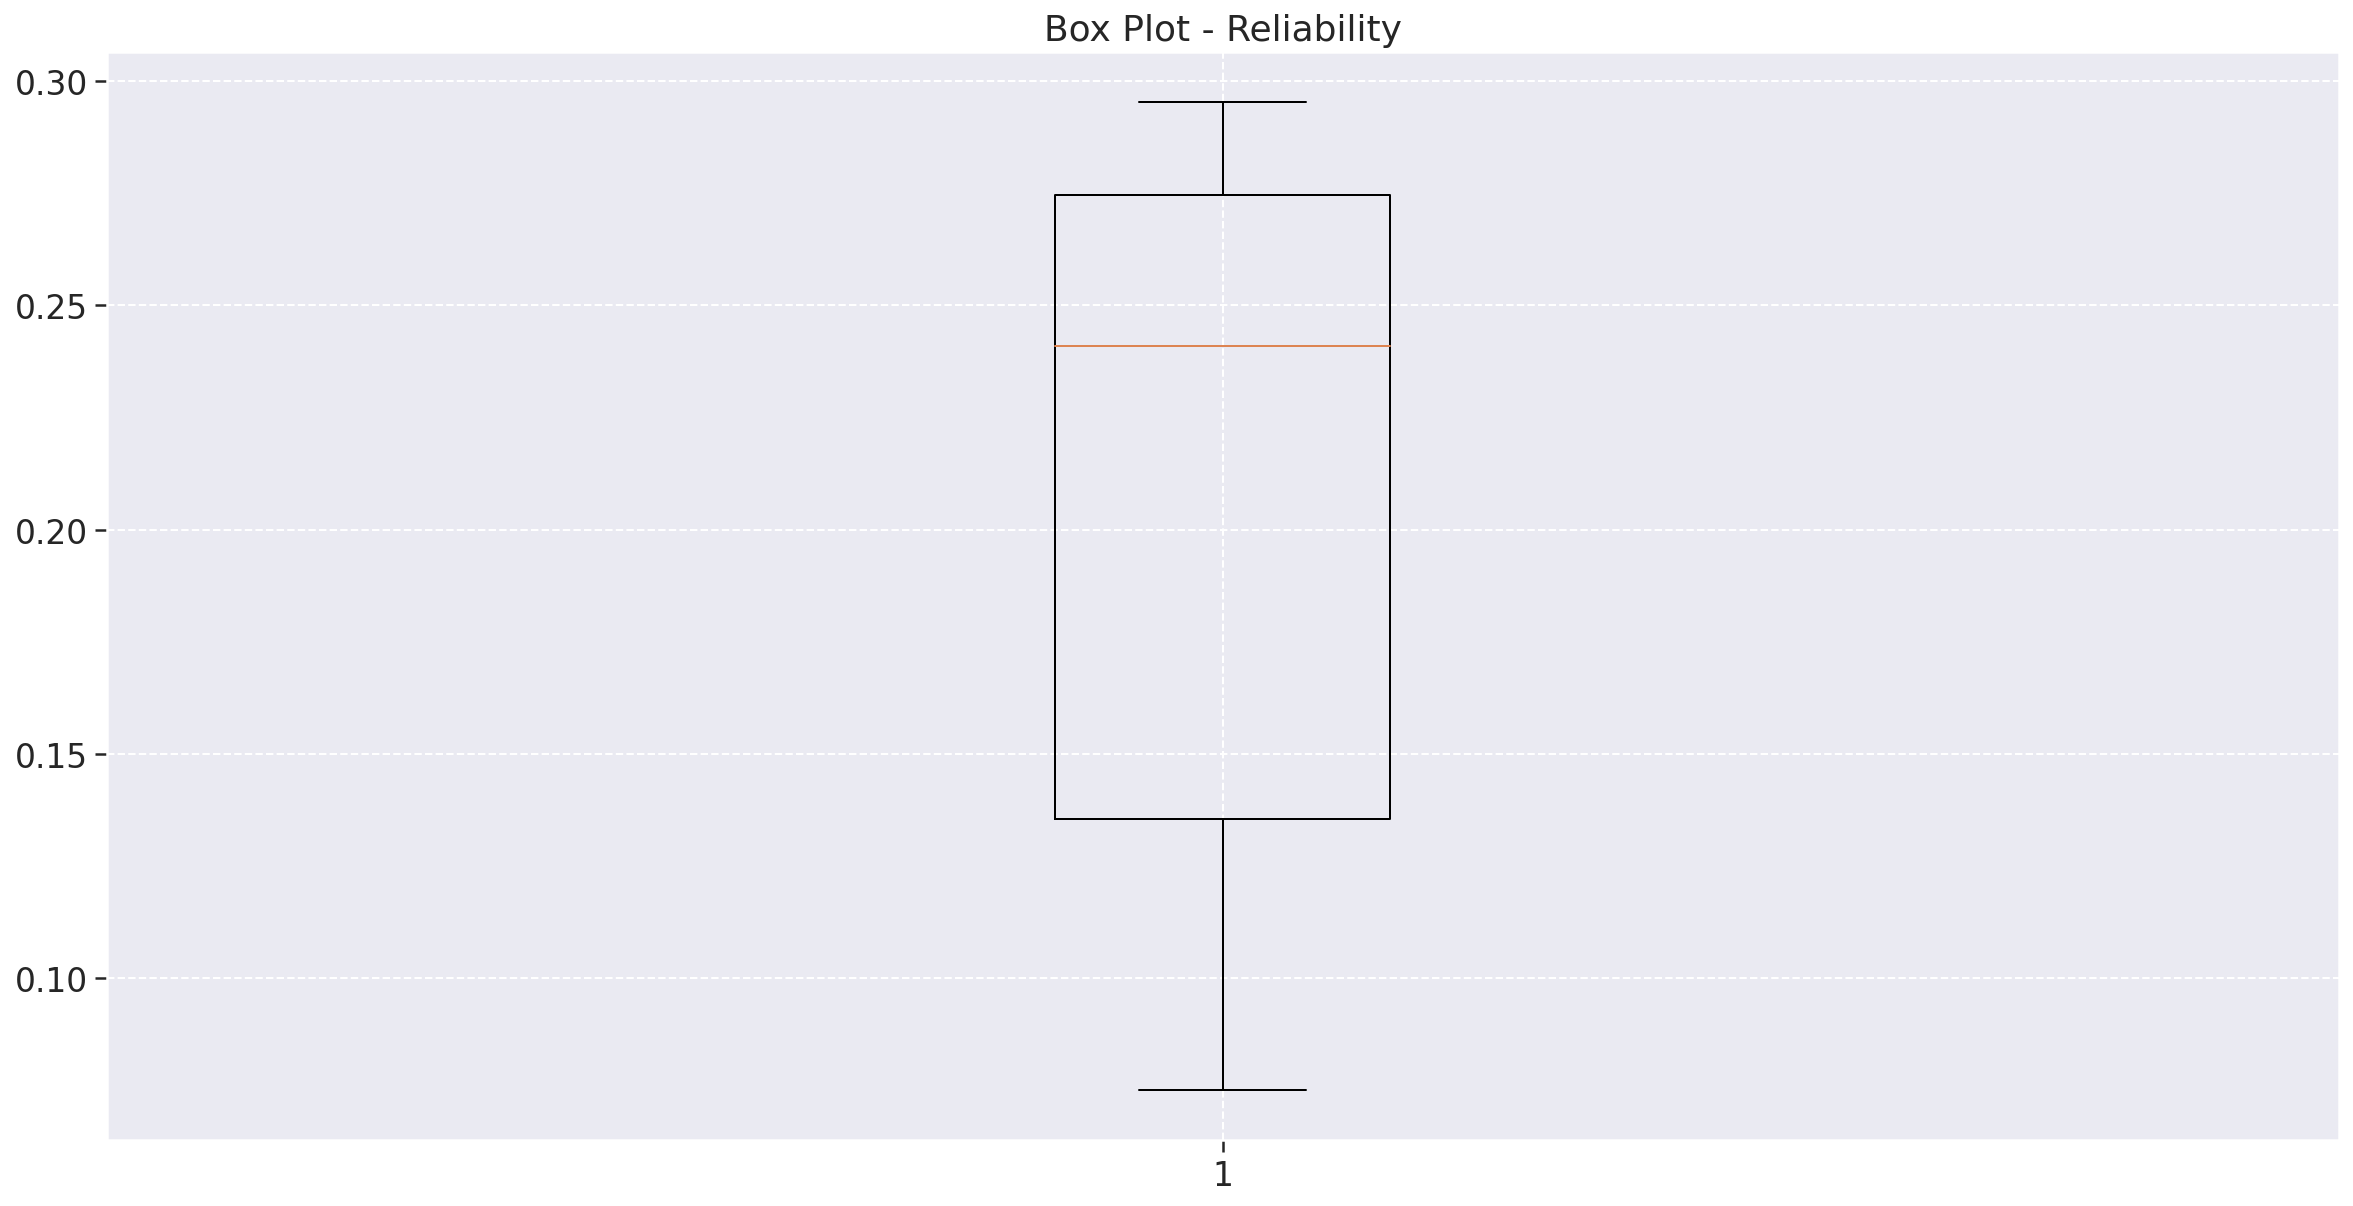

In [43]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Reliability')
plt.boxplot(metrics_df['Reliability'])

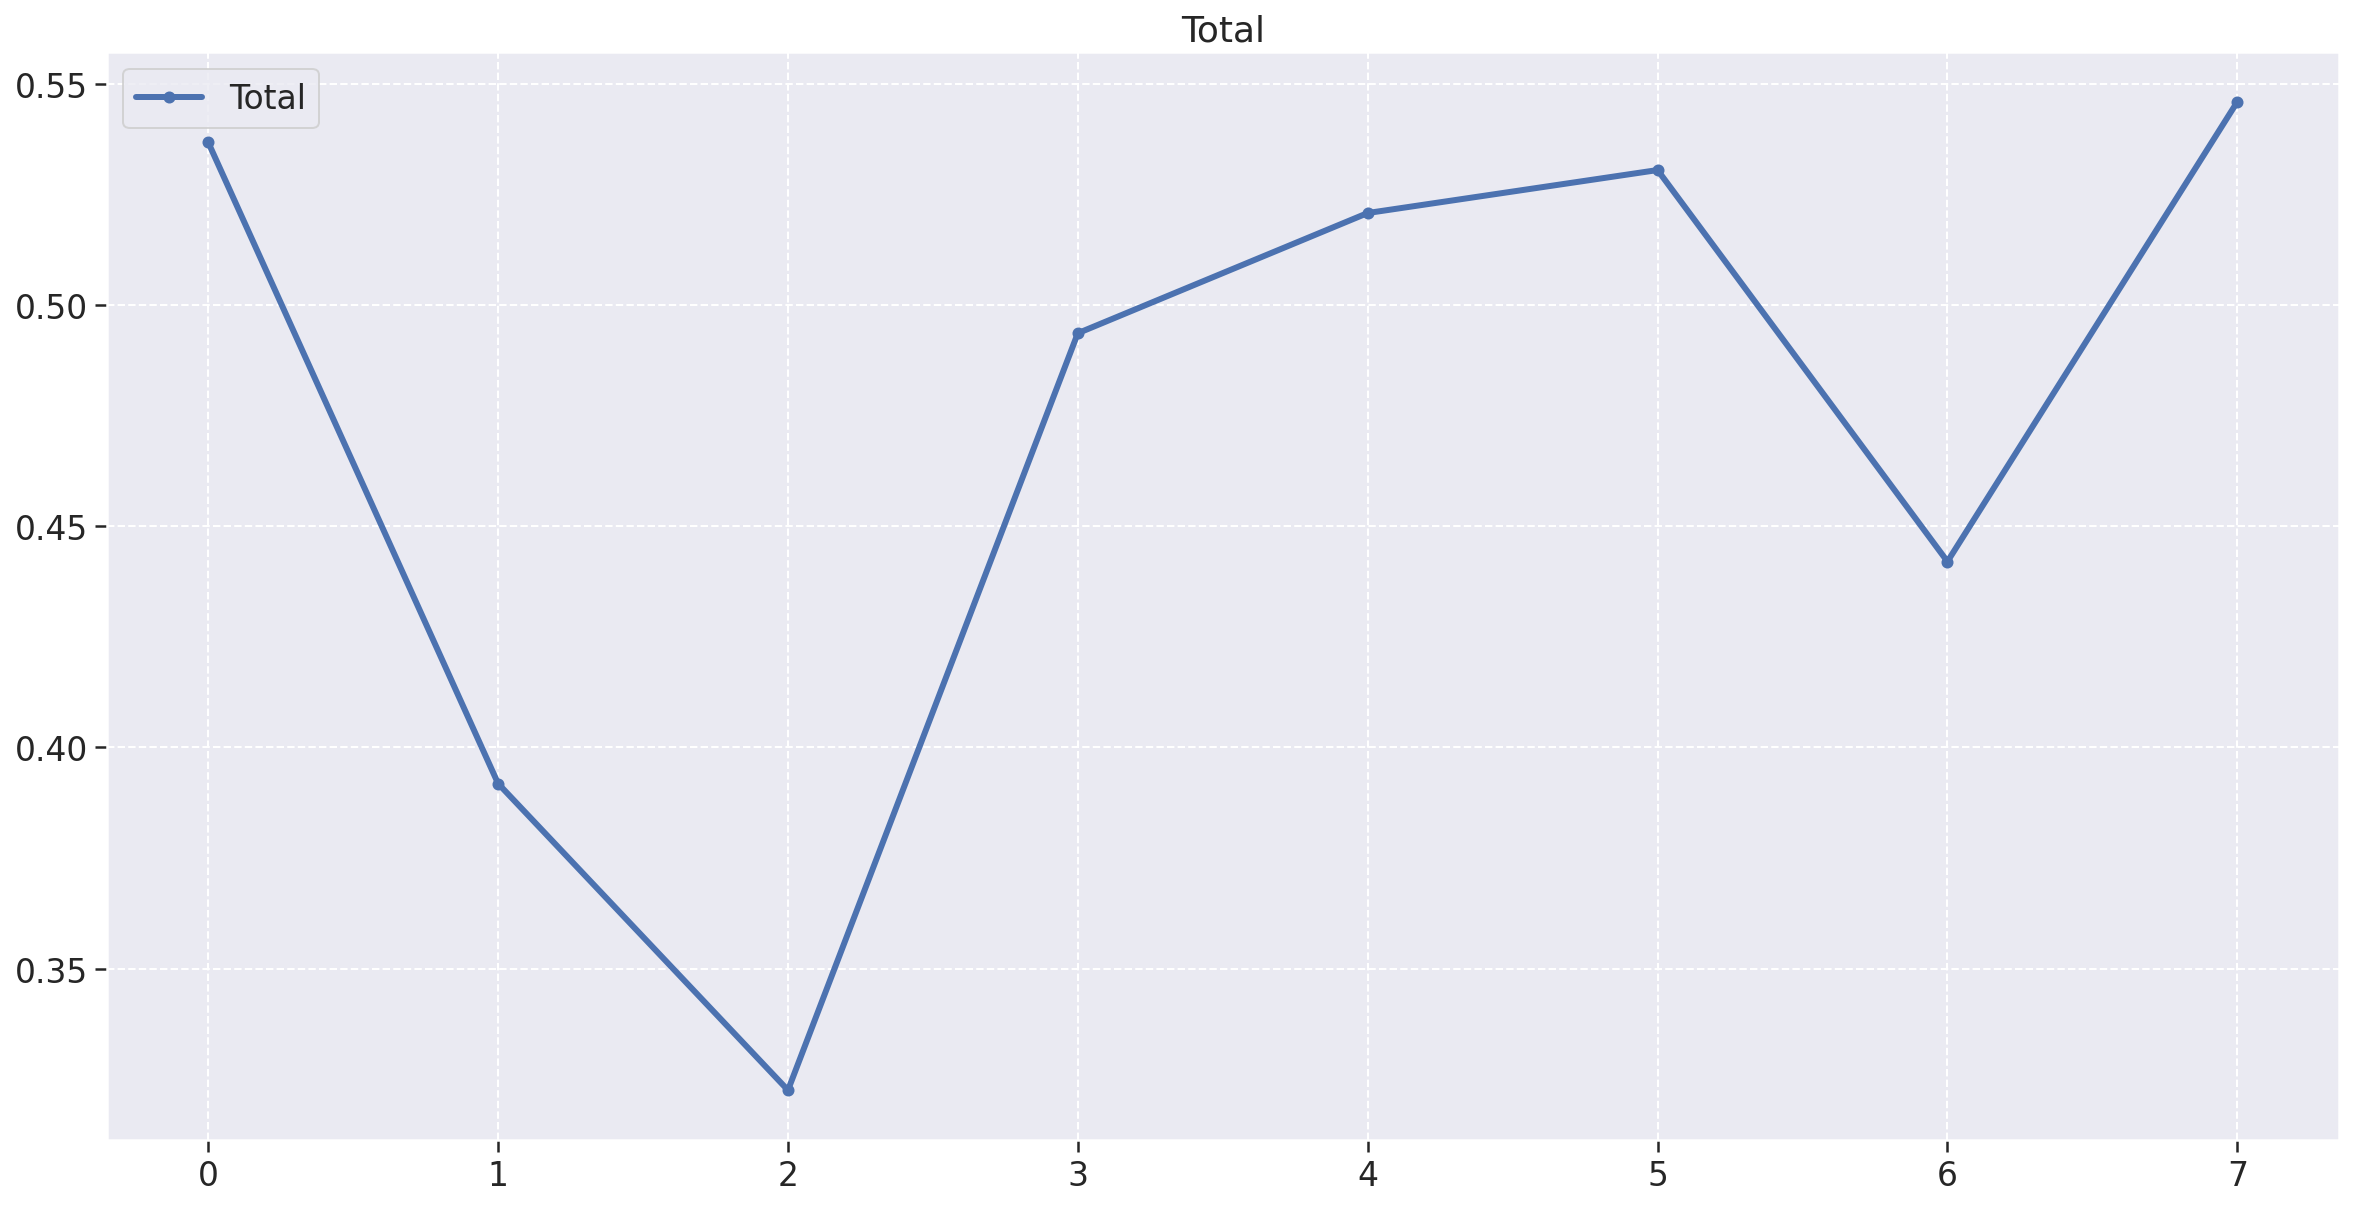

In [44]:
fig = plt.figure(figsize=(20, 10))

plt.title('Total')
plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5, label='Total')

plt.legend(loc='upper left')

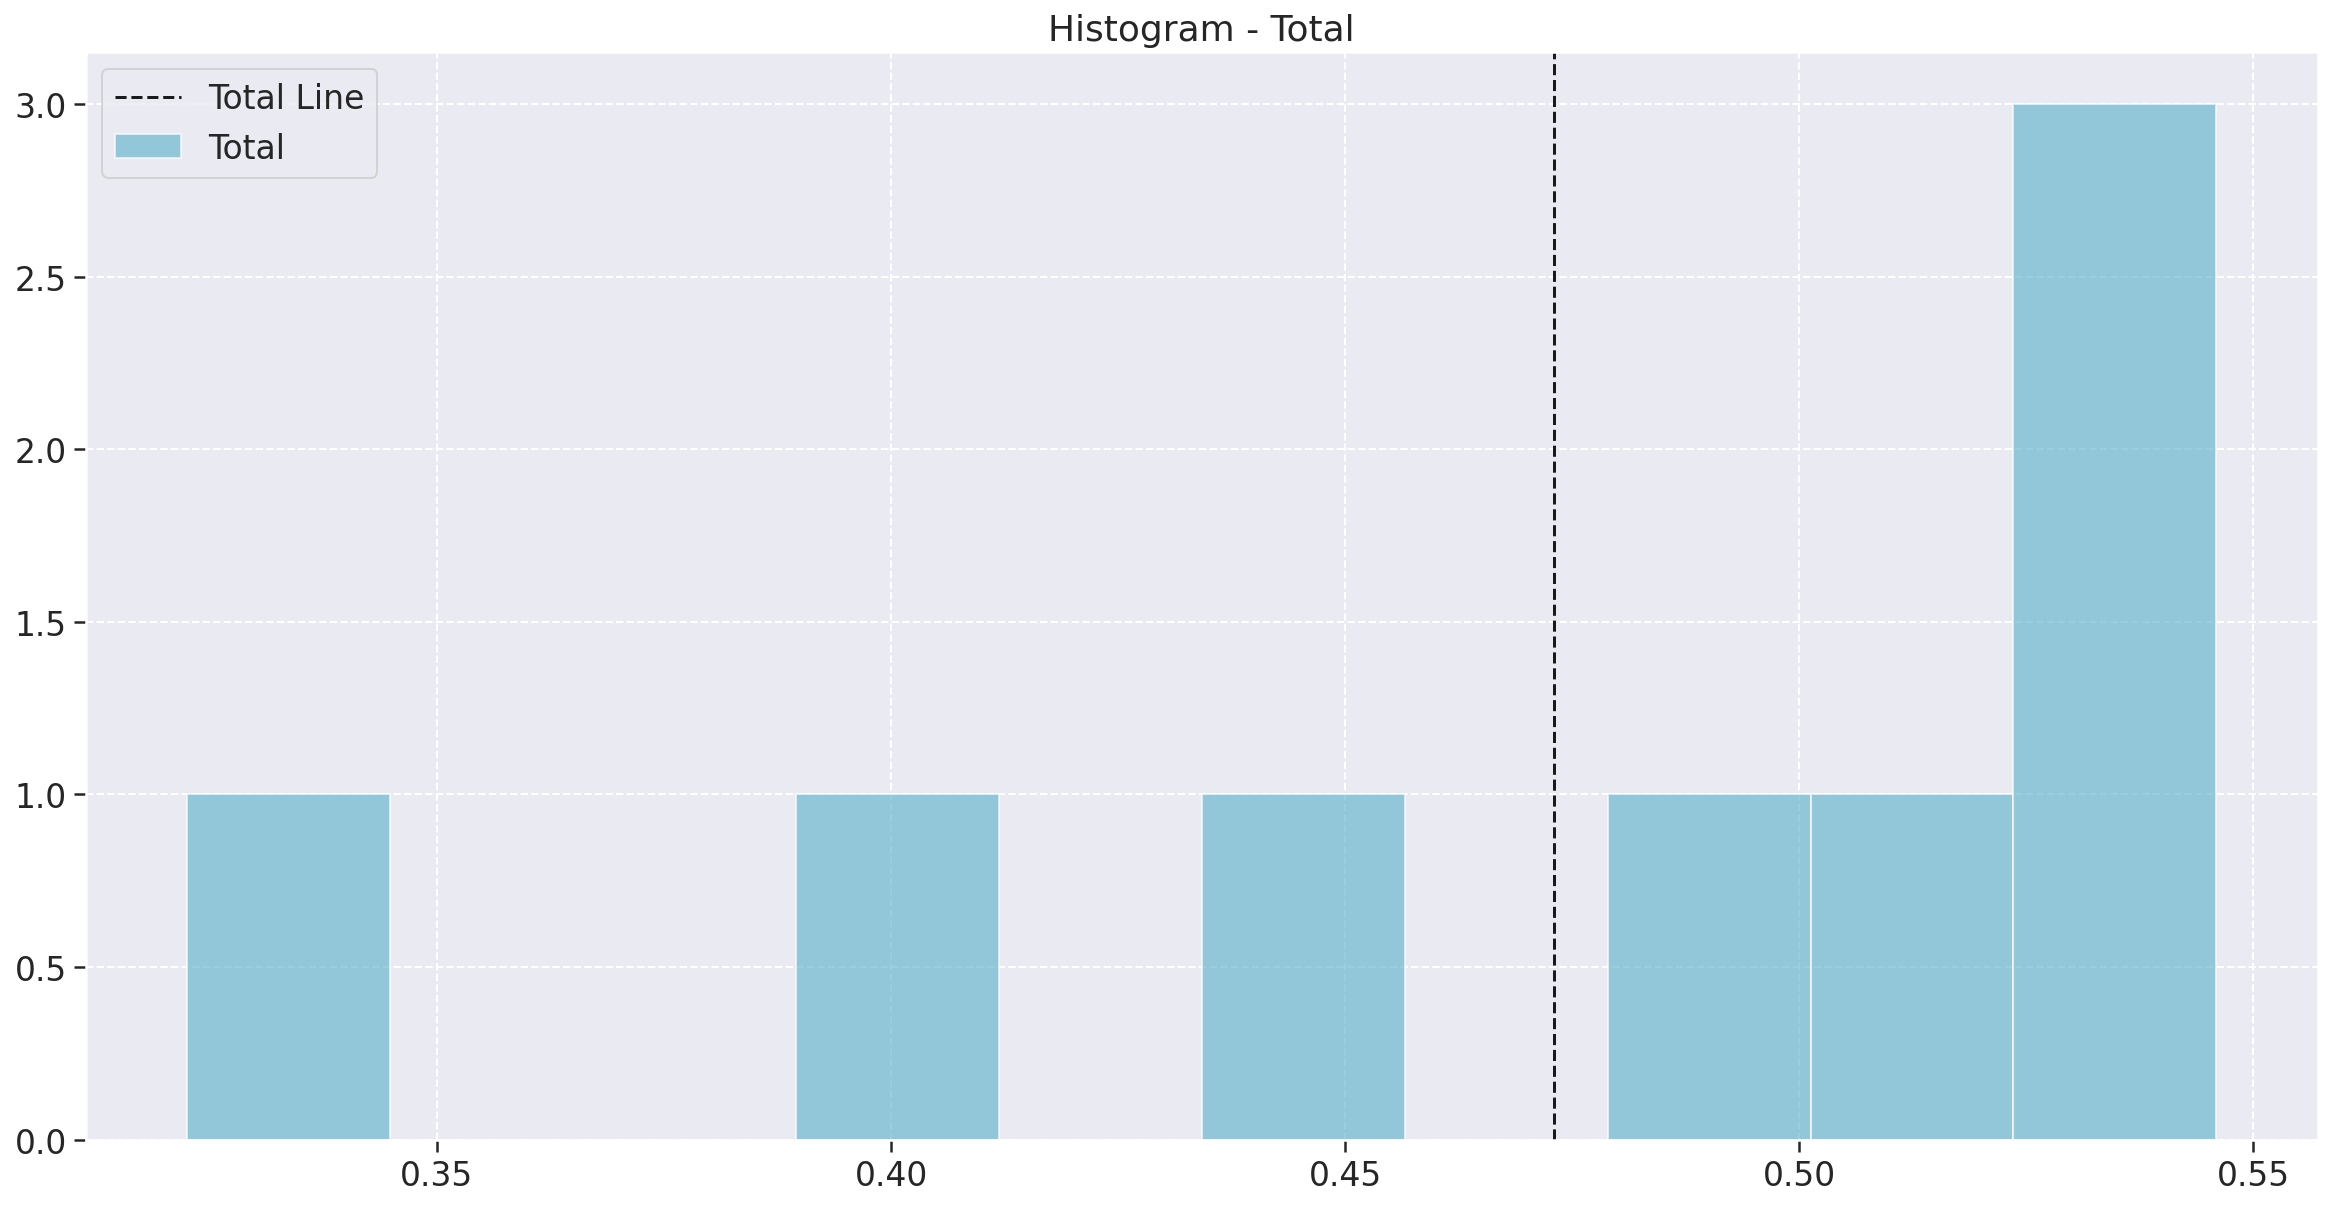

In [45]:
fig = plt.figure(figsize=(20, 10))

plt.title('Histogram - Total')
plt.hist(metrics_df['total'], bins=10, color='c', alpha=0.65, label='Total')
plt.axvline(metrics_df['total'].mean(), color='k', linestyle='dashed', label='Total Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2b74eb83d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2b74eb8af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2b74eb8160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2b74ec4250>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2b74ec45e0>],
 'means': []}

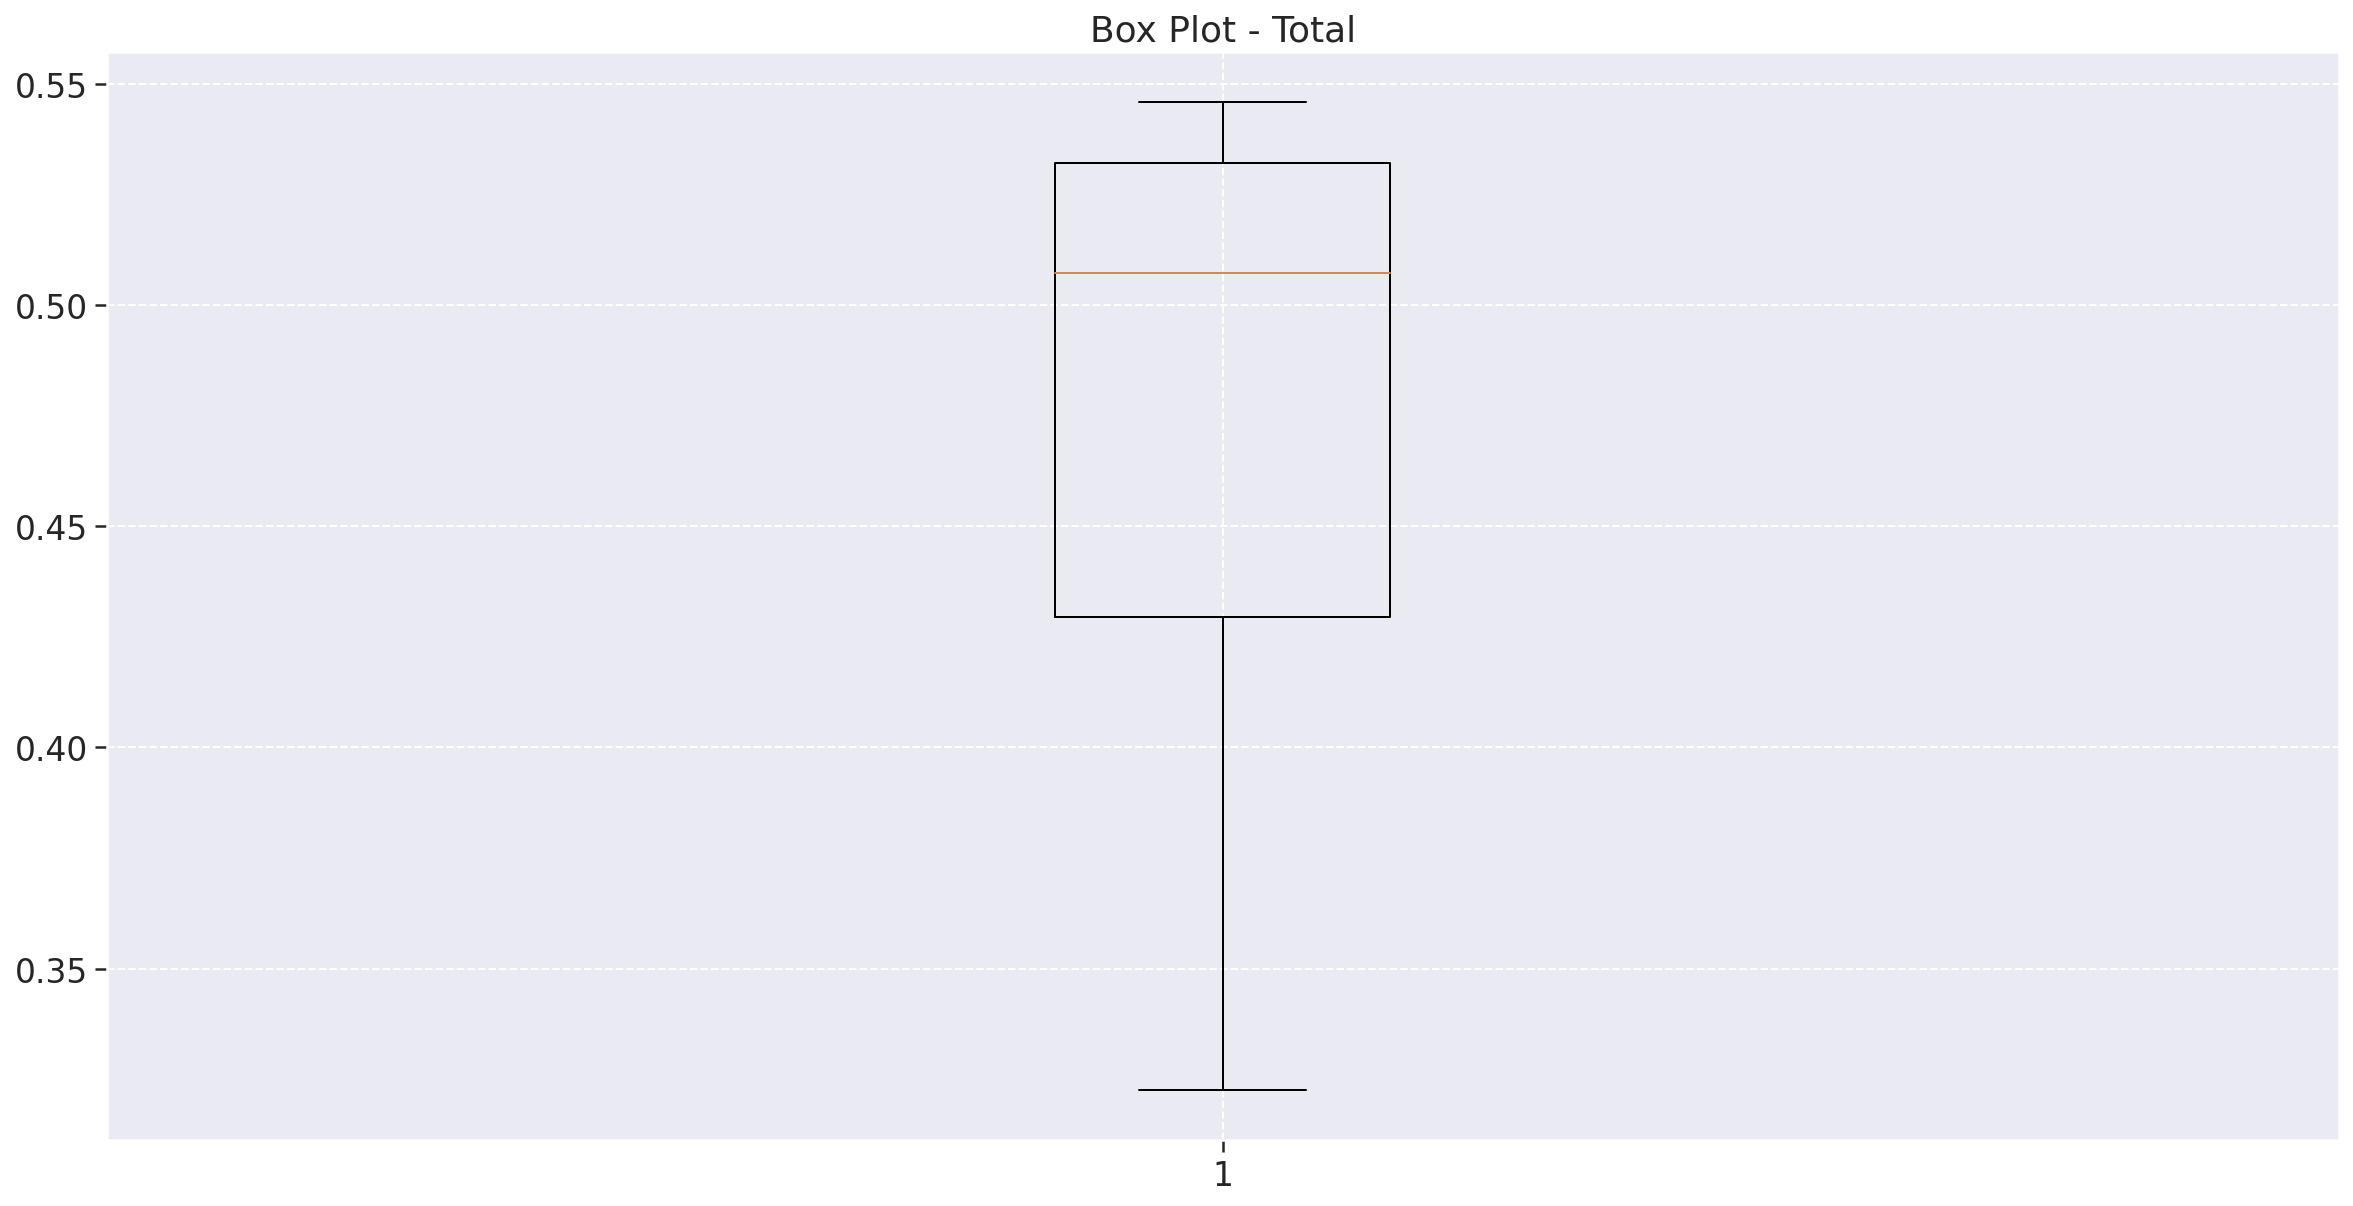

In [46]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Total')
plt.boxplot(metrics_df['total'])

### Explanation

TODO :
- Textual explanation of the observed behavior of the total quality of the system. In essence, this is the analytical description, from the team's point of view, of the explanations of internal quality behavior over the observation period. 

Text(0.5, 1.0, 'Matriz de Correção')

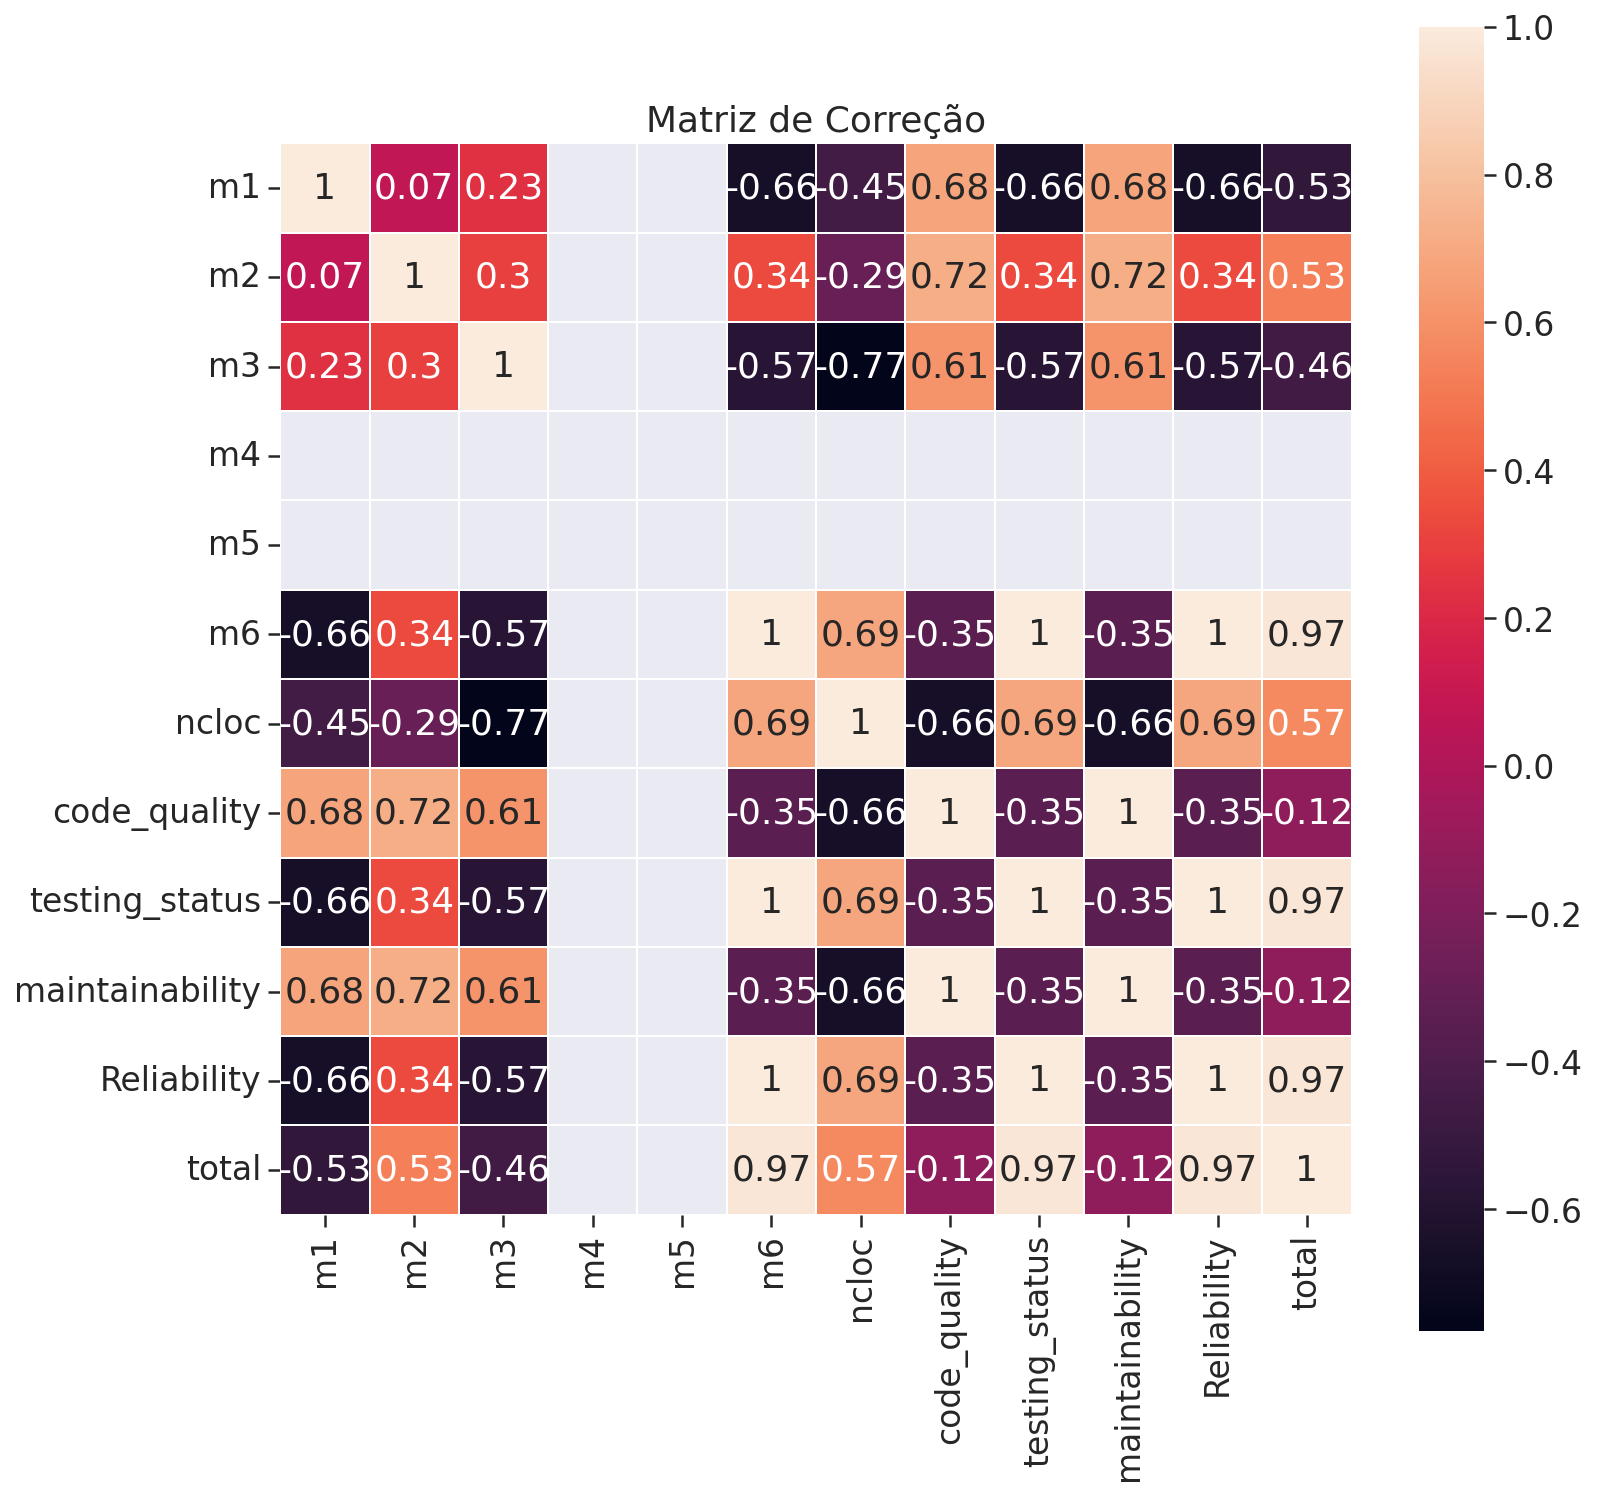

In [47]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(metrics_df.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção')

In [48]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,0.432432,0.162162,1.000000,1.0,0.0,0.567568,Scraper,02-11-2021-23-26,1348.0,0.526216,0.547297,0.263108,0.273649,0.536757
1,0.636364,0.090909,1.000000,1.0,0.0,0.090909,Scraper,07-10-2021-07-43,484.0,0.570000,0.213636,0.285000,0.106818,0.391818
2,0.500000,0.000000,1.000000,1.0,0.0,0.000000,Scraper,15-09-2021-00-01,138.0,0.495000,0.150000,0.247500,0.075000,0.322500
3,0.482759,0.103448,1.000000,1.0,0.0,0.448276,Scraper,21-10-2021-15-11,1058.0,0.523448,0.463793,0.261724,0.231897,0.493621
4,0.500000,0.052632,0.921053,1.0,0.0,0.578947,Frontend,02-11-2021-23-30,2460.0,0.486316,0.555263,0.243158,0.277632,0.520789
5,0.500000,0.200000,1.000000,1.0,0.0,0.500000,Frontend,07-10-2021-11-50,125.0,0.561000,0.500000,0.280500,0.250000,0.530500
6,0.600000,0.200000,1.000000,1.0,0.0,0.200000,Frontend,15-09-2021-00-47,58.0,0.594000,0.290000,0.297000,0.145000,0.442000
7,0.481481,0.111111,0.925926,1.0,0.0,0.629630,Frontend,27-10-2021-17-37,1334.0,0.501111,0.590741,0.250556,0.295370,0.545926


In [50]:
# ANALYSIS_DATE FORMAT: YYYY-MM-DD
currentTime = datetime.datetime.now().strftime("%Y-%m-%d")

metrics_df.to_excel('./data/fga-eps-mds-2021_1-PCTs-DATASET-{}.xlsx'.format(currentTime), index = False)
metrics_df.to_csv('./data/fga-eps-mds-2021_1-PCTs-DATASET-{}.csv'.format(currentTime), index = False)